<a href="https://colab.research.google.com/github/deniseiras/Forex_RNN/blob/main/Forex_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Rede RNN (LSTM) - Moeda

Denis M. A. Eiras
Atualizado: 17/10/2023

O notebook objetiva fazer a predição das moedas EURO e DÓLAR dos últimos 20 dias e comparar com os dados observados. Ainda, fazer a predição futura dos próximos 20 dias.

O dataset é disponibilizado através do uso da API yahoo finance.

Tempo aproximado de execução de xxx minutos


## Parâmetros gerais

In [1]:
 # Pode-se parametrizar o melhor modelo manualmente na seção Treinamento e Hiperparametrização
 # Para isso, use search_best_model = False. Se true, busca pelos melhores parâmetros
search_best_model = True

# common model hyperparameters
validation_split = 0.1
metrics_used = ['mae', 'mse']
# manual train times
# TODO Auto train times
train_times = 1
epochs = 50


## Inicialização das bibliotecas


In [2]:
import numpy as np
from keras.models import Model, Sequential, model_from_json
from keras.layers import LSTM, Input, Dropout, Dense, RepeatVector, TimeDistributed, Conv1D, Flatten, MaxPooling1D, \
  BatchNormalization, Activation, Layer
from keras.regularizers import l2
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import pickle
#import glob
!pip install yfinance
import yfinance as yf
from IPython import display
import sys
import warnings
from time import time
from datetime import datetime, timedelta
from random import uniform
import json

!pip install -q -U keras-tuner
import keras_tuner as kt

warnings.filterwarnings('ignore')
print("")
print("Python version:")
print (sys.version)
print("\nTensorflow version:")
print(tf.__version__)
print('')

starts_at = datetime.now()
print(f'Starting at {starts_at}')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 23.9 MB/s eta 0:00:00
Using TensorFlow backend

Python version:
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

Tensorflow version:
2.13.0

Starting at 2023-10-19 14:51:36.269430


Informações sobre o dólar USD

In [3]:
eurobrl = "EURBRL=X"
usdbrl = "USDBRL=X"
btcusd = "BTC-USD"
msft = yf.Ticker(usdbrl)

# get stock info
print(msft.info)

# get historical market data
hist = msft.history(period="max")

# show actions (dividends, splits)
# print(msft.actions)

# show dividends
print(msft.dividends)

# show splits
print(msft.splits)

# show major holders
print(msft.major_holders)

# show institutional holders
print(msft.institutional_holders)


{'maxAge': 86400, 'priceHint': 4, 'previousClose': 5.0593, 'open': 5.0505, 'dayLow': 5.05, 'dayHigh': 5.0826, 'regularMarketPreviousClose': 5.0593, 'regularMarketOpen': 5.0505, 'regularMarketDayLow': 5.05, 'regularMarketDayHigh': 5.0826, 'volume': 0, 'regularMarketVolume': 0, 'averageVolume': 0, 'averageVolume10days': 0, 'averageDailyVolume10Day': 0, 'bid': 5.0597, 'ask': 5.0617, 'bidSize': 0, 'askSize': 0, 'fiftyTwoWeekLow': 4.695682, 'fiftyTwoWeekHigh': 5.519577, 'fiftyDayAverage': 4.972916, 'twoHundredDayAverage': 5.000851, 'currency': 'BRL', 'exchange': 'CCY', 'quoteType': 'CURRENCY', 'symbol': 'BRL=X', 'underlyingSymbol': 'BRL=X', 'shortName': 'USD/BRL', 'longName': 'USD/BRL', 'firstTradeDateEpochUtc': 1070236800, 'timeZoneFullName': 'Europe/London', 'timeZoneShortName': 'BST', 'uuid': '7d54f13b-191f-3066-8bba-61044ece2b5c', 'messageBoardId': 'finmb_BRL_X', 'gmtOffSetMilliseconds': 3600000, 'trailingPegRatio': None}
Series([], Name: Dividends, dtype: float64)
Series([], Name: Stoc

## Leitura e tratamento do Dataset



Requisição de dados para API *Yahoo Finance* e visualização de informações básicas.

---



[*********************100%%**********************]  2 of 2 completed
Data Inicial:  2003-12-01 00:00:00
Data Final  :  2023-10-19 00:00:00
Tamanho     :  4732



Text(0.5, 1.0, 'Preço de Encerramento')

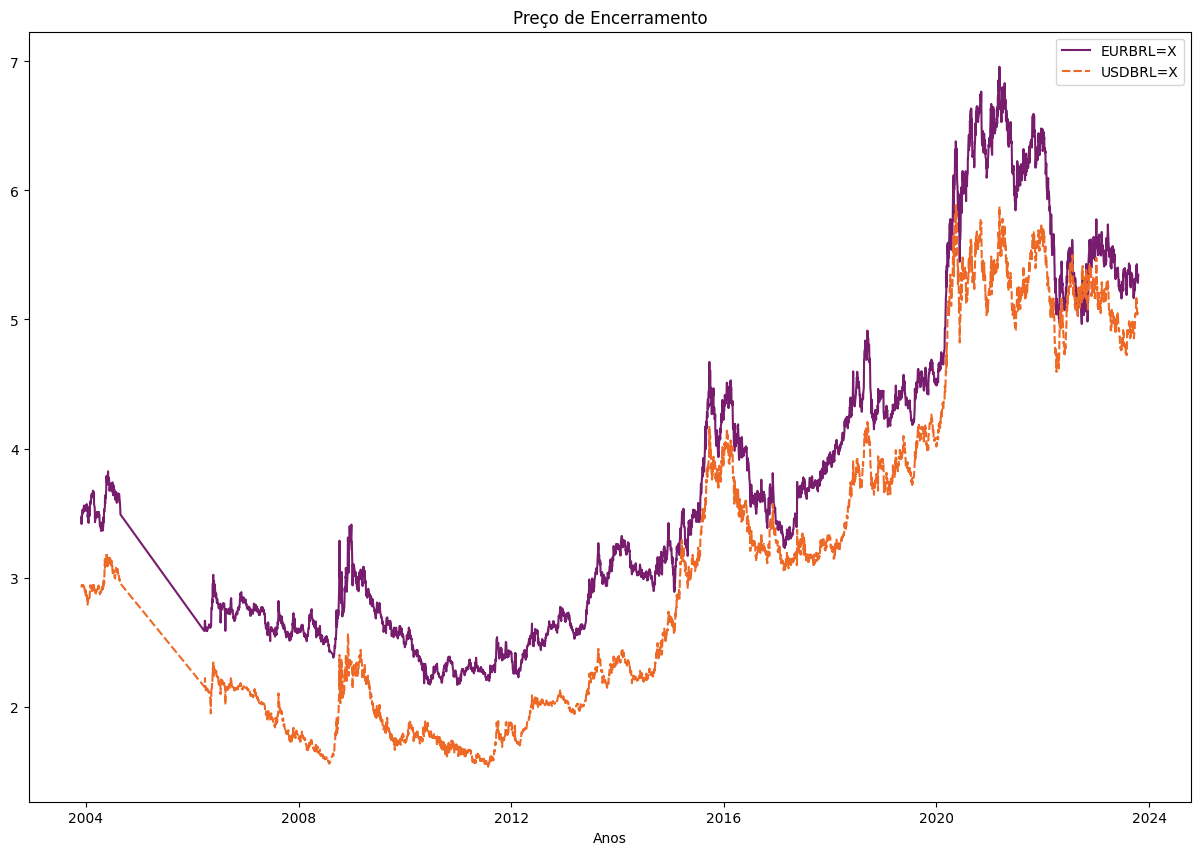

In [4]:
arr_acoes = [eurobrl, usdbrl]

data = yf.download(arr_acoes)

df = data["Close"]
df.dropna(axis=0, inplace=True)
print("Data Inicial: ", df.index.min())
print("Data Final  : ", df.index.max())
print("Tamanho     : ", len(df))
print('')

fig, ax = plt.subplots(figsize=(15, 10), nrows=1, ncols=1)
sns.lineplot(data=df, palette='inferno', ax=ax,hue_order=arr_acoes)
ax.set_xlabel('Anos')
ax.set_title('Preço de Encerramento')

In [5]:
df.describe()

,EURBRL=X,USDBRL=X
count,4732.000000,4732.000000
mean,3.716100,3.112639
std,1.269469,1.287403
min,2.167800,1.533700
25%,2.634450,2.011725
50%,3.356950,2.921000
75%,4.442425,3.960375
max,6.959100,5.886400


In [6]:
df

,EURBRL=X,USDBRL=X
Date,,
2003-12-01,3.4621,2.9230
2003-12-02,3.4151,2.9310
2003-12-03,3.4799,2.9310
2003-12-04,3.4597,2.9430
2003-12-05,3.4794,2.9340
...,...,...
2023-10-13,5.3113,5.0459
2023-10-16,5.2840,5.0482
2023-10-17,5.3135,5.0376


Seleção e visualização do dataset de Treino e Teste.

---



Data Inicial Treino:  2003-12-01 00:00:00
Data Final   Treino:  2023-09-21 00:00:00
Tamanho      Treino:  4712

Data Inicial Teste:  2023-09-22 00:00:00
Data Final   Teste:  2023-10-19 00:00:00
Tamanho      Teste:  20


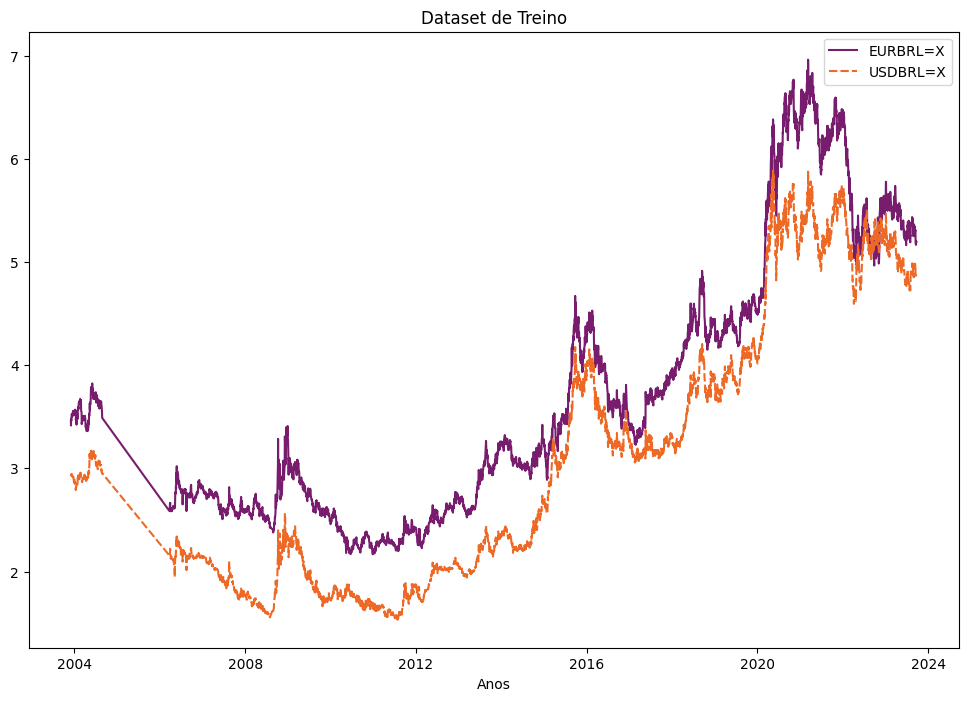

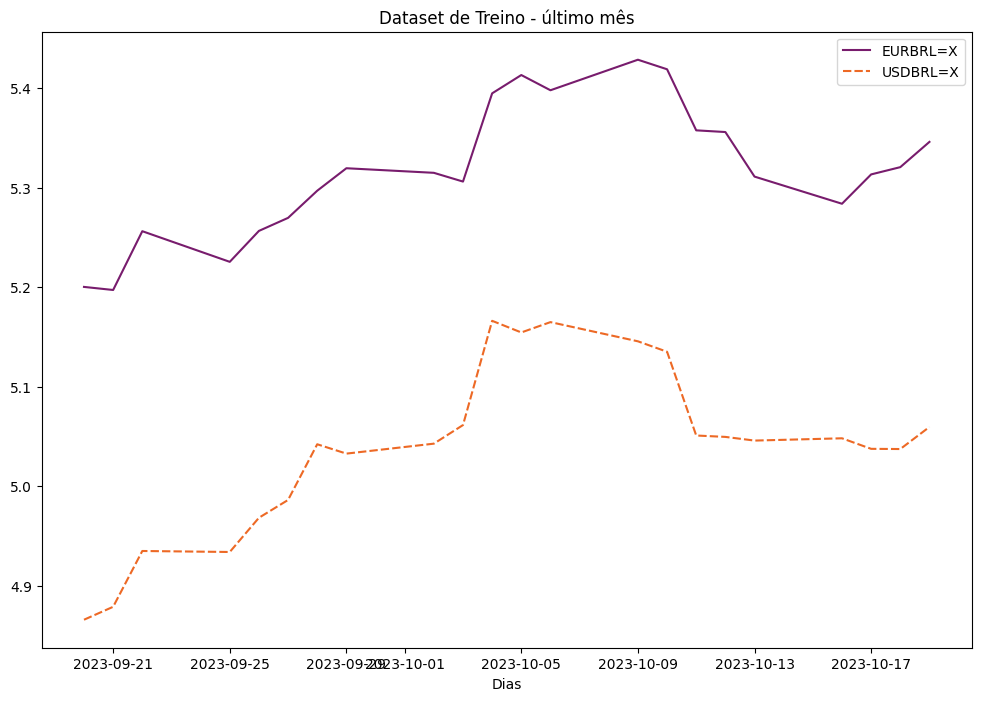

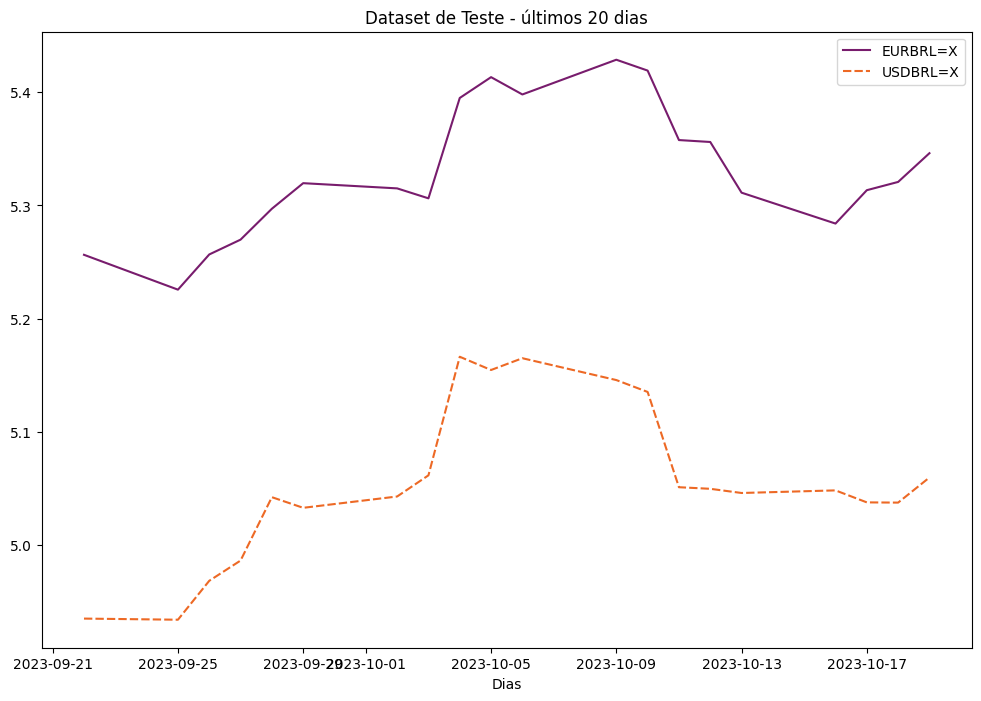

In [7]:
today = datetime.today()

# prev últimos dias úteis
dias_teste = 20

data_corte_treino = today - timedelta(days=1)
while True:
  data_treino = df.loc[(df.index <= data_corte_treino)]
  data_teste = df.loc[(df.index > data_corte_treino)]
  if len(data_teste) == dias_teste:
    break
  data_corte_treino = data_corte_treino - timedelta(days=1)


print("Data Inicial Treino: ", data_treino.index.min())
print("Data Final   Treino: ", data_treino.index.max())
print("Tamanho      Treino: ", len(data_treino))
print('')

print("Data Inicial Teste: ", data_teste.index.min())
print("Data Final   Teste: ", data_teste.index.max())
print("Tamanho      Teste: ", len(data_teste))

fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.lineplot(data=data_treino, palette="inferno", ax=ax, hue_order=arr_acoes)
ax.set_xlabel('Anos')
ax.set_title('Dataset de Treino')
# ax.set_ylim([0, 80])
plt.show()
print('')


# variáveis não usadas para treino, apenas visualização
tmp_data_corte_treino_30dias = today - timedelta(days=30)
tmp_data_treino_30dias = df.loc[(df.index >= tmp_data_corte_treino_30dias)]
fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.lineplot(data=tmp_data_treino_30dias, palette="inferno", ax=ax, hue_order=arr_acoes)
ax.set_xlabel('Dias')
ax.set_title('Dataset de Treino - último mês')
# ax.set_ylim([0, 80])
plt.show()
print('')

fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.lineplot(data=data_teste, palette="inferno", ax=ax, hue_order=arr_acoes)
ax.set_xlabel('Dias')
ax.set_title(f'Dataset de Teste - últimos {dias_teste} dias')
plt.show()

## Pré Processamento

Função utilizada na transformação da base de dados em 3 dimensões, contendo:

1.   Uma sequência ou mais de exemplos (Batch Size);
2.   Um ponto ou mais de observações em série temporal (Time Steps);
3.   Numero de váriaveis contidas em cada Time Step (Features).

---



In [8]:
def preprocess(dataset, stock, TimeSteps, TesteLen):

    # StandardScaler
    n = len(dataset[[stock]])
    scaler = StandardScaler()
    scaler = scaler.fit(dataset[[stock]])

    df_scal = scaler.transform(dataset[[stock]])
    df_scal = df_scal.reshape(n, 1)

    X = df_scal
    X_samples = list()
    y_samples = list()

    NumerOfRows = len(X)
    for i in range(int(TimeSteps) , NumerOfRows , 1):
        x_sample = X[i-TimeSteps:i]
        y_sample = X[i]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    X_data=np.array(X_samples)
    X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)

    y_data=np.array(y_samples)
    y_data=y_data.reshape(y_data.shape[0], 1)

    # Separando dataset entre treino e teste
    if TesteLen > 0:
      X_train=X_data[:-TesteLen]
      X_test=X_data[-TesteLen:]
      y_train=y_data[:-TesteLen]
      y_test=y_data[-TesteLen:]
    else:
      X_train=X_data
      X_test=[]
      y_train=y_data
      y_test=[]
    return scaler, X_train, X_test, y_train, y_test


def preprocess_CNN1D(dataset, stock, TesteLen):
    # StandardScaler
    n = len(dataset[[stock]])
    scaler = StandardScaler()
    scaler = scaler.fit(dataset[[stock]])

    df_scal = scaler.transform(dataset[[stock]])
    df_scal = df_scal.reshape(n, 1)

    X = np.array(df_scal)
    # Separando dataset entre treino e teste
    if TesteLen > 0:
      X_train = X[:-TesteLen]
      X_test = X[-TesteLen:]
    else:
      X_train = X_train
      X_test = []

    y_train, y_test = X_train, X_test
    X_train = X_train.reshape(X_train.shape[0], 1, 1)
    X_test = X_test.reshape(X_test.shape[0], 1, 1)

    return scaler, X_train, X_test, y_train, y_test




Exemplo de transformação do dataset, utilizando 10 observações por batch, separando os ultimos len(data_teste) registros para avaliação dos melhores modelos.



In [9]:
timesteps = 10
print("LSTM data\n\n")
scaler, X_train, X_test, y_train, y_test = preprocess(df, eurobrl, timesteps, len(data_teste))
for inp, out in zip(X_train[0:3], y_train[0:3]):
  print(inp,'--', out)

print("CNN1D data\n\n")
scaler, X_train, X_test, y_train, y_test = preprocess_CNN1D(df, eurobrl, len(data_teste))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
for inp, out in zip(X_train[0:3], y_train[0:3]):
  print(inp,'--', out)

LSTM data


[[-0.20010473]
 [-0.23713194]
 [-0.18608175]
 [-0.20199542]
 [-0.18647563]
 [-0.16433804]
 [-0.1496847 ]
 [-0.15874447]
 [-0.17300393]
 [-0.15055116]] -- [-0.16520449]
[[-0.23713194]
 [-0.18608175]
 [-0.20199542]
 [-0.18647563]
 [-0.16433804]
 [-0.1496847 ]
 [-0.15874447]
 [-0.17300393]
 [-0.15055116]
 [-0.16520449]] -- [-0.15220556]
[[-0.18608175]
 [-0.20199542]
 [-0.18647563]
 [-0.16433804]
 [-0.1496847 ]
 [-0.15874447]
 [-0.17300393]
 [-0.15055116]
 [-0.16520449]
 [-0.15220556]] -- [-0.13337696]
CNN1D data


(4712, 1, 1) (20, 1, 1) (4712, 1) (20, 1)
[[-0.20010473]] -- [-0.20010473]
[[-0.23713194]] -- [-0.23713194]
[[-0.18608175]] -- [-0.18608175]


## Treinamento e Hiperparâmetrização

Consiste em duas técnicas: automática e manual

Variáveis e hiperparâmetros comuns para hiperparametrização automática e manual

In [10]:
cfg_res_cols = ["model_type","stock", "num_layers", "unit","optimizer", "activation", "dropout_rate", "mae", "mse", "batch_size", "timesteps"]
all_results = pd.DataFrame(columns=cfg_res_cols)

arr_acoes_hyperparams = arr_acoes
best_models_df = pd.DataFrame(columns=["model"] + cfg_res_cols)

if search_best_model:

  # Hyperparams

  model_hyperparams = ['AUTO', 'LSTM_v1', 'LSTM_v2']

  # common hyper for auto and manual
  unit_hyper = range(32, 65, 32)
  batch_hyper = range(8, 17, 8)
  timesteps_hyper = range(10, 21, 10)
  optimizer_hyper = ['adam', 'sgd']

  # params varied only in auto
  max_layers_hyperparam = 3
  dropout_hyper = [0.0, 0.5]
  dropout_hyper_step = 0.1
  # TODO - use rate in manual train
  learn_rate_hyper = [1e-2, 1e-3, 1e-4]
  # TODO - use activation in manual train
  activation_hyper = ['relu', 'tanh']

else:
  # TODO - Best model for each stock
  # Best model found =============================
  model_hyperparams = ['AUTO']

  # common hyper for auto and manual
  unit_hyper = range(64, 65)
  batch_hyper = range(8, 9)
  timesteps_hyper = range(10, 11)
  optimizer_hyper = ['sgd']

  # params varied only in auto
  max_layers_hyperparam = 1
  dropout_hyper = [0.0, 0.0]
  dropout_hyper_step = 0.1
  learn_rate_hyper = [0.2]
  activation_hyper = ['tanh']


Funções para obter hyperparâmetros de um modelo

In [11]:
def get_model_info(model):
    optimizer = model.optimizer.__class__.__name__.lower()
    num_layers = int(len(model.layers))
    units = None
    activation = None
    dropout_rate = 0.0
    for layer in model.layers:
        if isinstance(layer, LSTM):
          units = layer.units
          activation = layer.get_config()['activation']
        if isinstance(layer, Dropout):
          dropout_rate = layer.get_config().get('rate')

    return optimizer, num_layers, units, activation, dropout_rate


In [12]:
def get_early_stopping(patience):
  return tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=patience, mode='min', restore_best_weights=True)

### Auto Tunning
Usa BaesyanOptimization


Funções

In [13]:
def build_model(hp):
    mod = Sequential()

    # Tune the number of LSTM layers
    num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=max_layers_hyperparam, step=1)

    for _ in range(num_lstm_layers):
        mod.add(LSTM(units=hp.Int('units', min_value=unit_hyper.start, max_value=unit_hyper.stop, step=unit_hyper.step),
                     activation=hp.Choice('activation', values=activation_hyper),
                     input_shape=(timesteps, 1), return_sequences=True))  # Use return_sequences=True for multiple LSTM layers
        mod.add(Dropout(rate=hp.Float('dropout', min_value=dropout_hyper[0], max_value=dropout_hyper[-1], step=dropout_hyper_step)))  # Tune dropout rate


    # batch_size = hp.Int('batch_size', min_value=8, max_value=128, step=8)  # Tune the batch size

    mod.add(LSTM(units=hp.Int('units',  min_value=unit_hyper.start, max_value=unit_hyper.stop, step=unit_hyper.step),
                 activation=hp.Choice('activation', values=activation_hyper),
                 input_shape=(timesteps, 1), return_sequences=False))

    mod.add(Dense(1, activation='linear'))

    # Choose an optimizer and learning rate from the search space
    optimizer = hp.Choice('optimizer', values=optimizer_hyper)
    learning_rate = hp.Choice('learning_rate', values=learn_rate_hyper)

    mod.compile(loss=tf.losses.MeanSquaredError(), optimizer=optimizer, metrics=metrics_used)

    return mod


# TODO auto batch size
def auto_train_model(best_model, X, y, epochs, patience, batch_size=16 ):

  display.display(best_model.summary())
  # Train the best model
  hist = best_model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                        callbacks=[get_early_stopping(patience)])

  loss_metric_train = best_model.evaluate(X, y, verbose=0, batch_size=batch_size, use_multiprocessing=True)
  display.display( 'TRAINING set. Loss = {} , MAE = {}'.format(loss_metric_train[0], loss_metric_train[1])) #mse = loss and index 2

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(hist.history['loss'], label="Loss Treino")
  plt.plot(hist.history['val_loss'], label="Loss Validação")
  plt.plot(hist.history['mae'], label='MAE Validação')
  plt.ylim([0.0, 0.2])
  plt.xlim([0.0, epochs])
  plt.legend()
  plt.show()

  return best_model, hist


def auto_model_type(X, y, batch_size, epochs=50, patience=5):

  # Define the hyperparameter tuner
  tuner = kt.BayesianOptimization(
      build_model,            # Model-building function
      objective='val_loss',   # Objective to minimize (you can choose 'val_mae' or 'val_mse' as well)
      num_initial_points=5,   # Number of initial points for Bayesian optimization
      max_trials=10          # Total number of trials
      # seed=None
      # alpha=0.0001,
      # beta=2.6,
  )

  # Display search space summary
  tuner.search_space_summary()

  # Start the hyperparameter search
  tuner.search(X, y,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=validation_split,
              callbacks=[get_early_stopping(patience)]
  )

  # Get the best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  # Finally, you can retrieve the best model and train it using the best hyperparameters:
  best_model = build_model(best_hps)
  best_model, hist = auto_train_model(best_model, X, y, epochs, patience)

  return best_model, hist

Auto tunning e treinamento

Trial 10 Complete [00h 03m 32s]
val_loss: 0.013079827651381493

Best val_loss So Far: 0.002564712893217802
Total elapsed time: 00h 34m 35s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 64)            16896     
                                                                 
 dropout_2 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/50
265/265 [==============================] - 10s 20ms/step - loss: 0.0216 - mae: 0.0799 - mse: 0.0216 - val_loss: 0.0190 - val_mae: 0.1187 - val_mse: 0.0190
Epoch 2/50
265/265 [==============================] - 5s 18ms/step - loss: 0.0056 - mae: 0.0518 - mse: 0.0056 - val_loss: 0.0083 - val_mae: 0.0744 - val_mse: 0.0083
Epoch 3/50
265/265 [==============================] - 4s 15ms/step - loss: 0.0050 - mae: 0.0491 - mse: 0.0050 - val_loss: 0.0178 - val_mae: 0.1148 - val_mse: 0.0178
Epoch 4/50
265/265 [==============================] - 4s 16ms/step - loss: 0.0047 - mae: 0.0480 - mse: 0.0047 - val_loss: 0.0227 - val_mae: 0.1337 - val_mse: 0.0227
Epoch 5/50
265/265 [==============================] - 5s 19ms/step - loss: 0.0042 - mae: 0.0449 - mse: 0.0042 - val_loss: 0.0055 - val_mae: 0.0589 - val_mse: 0.0055
Epoch 6/50
265/265 [==============================] - 5s 17ms/step - loss: 0.0046 - mae: 0.0484 - mse: 0.0046 - val_loss: 0.0275 - val_mae: 0.1514 - val_mse: 0.0275
Epoch 7/5

'TRAINING set. Loss = 0.0017686925129964948 , MAE = 0.027851589024066925'

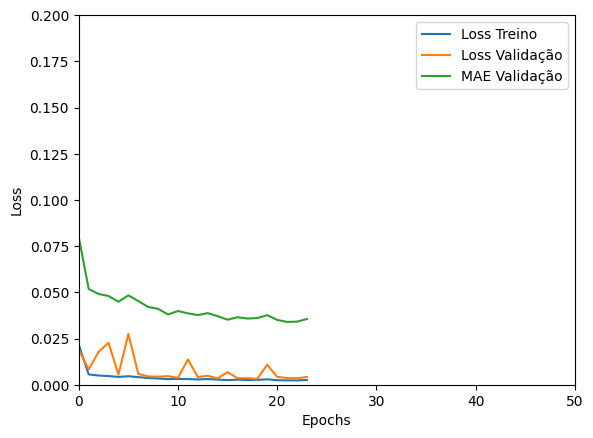

Tempo do auto treino: 0:38:00.183223
1/1 [==============================] - 1s 896ms/step
Auto Treinando EURBRL=X
Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 6
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 65, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Model: "sequential_2"
_________________________________________________________________
 Layer (type)       

None

Epoch 1/50
265/265 [==============================] - 11s 25ms/step - loss: 0.0304 - mae: 0.0871 - mse: 0.0304 - val_loss: 0.0157 - val_mae: 0.1055 - val_mse: 0.0157
Epoch 2/50
265/265 [==============================] - 4s 15ms/step - loss: 0.0059 - mae: 0.0542 - mse: 0.0059 - val_loss: 0.0095 - val_mae: 0.0802 - val_mse: 0.0095
Epoch 3/50
265/265 [==============================] - 4s 15ms/step - loss: 0.0048 - mae: 0.0485 - mse: 0.0048 - val_loss: 0.0325 - val_mae: 0.1632 - val_mse: 0.0325
Epoch 4/50
265/265 [==============================] - 5s 21ms/step - loss: 0.0046 - mae: 0.0473 - mse: 0.0046 - val_loss: 0.0319 - val_mae: 0.1628 - val_mse: 0.0319
Epoch 5/50
265/265 [==============================] - 4s 15ms/step - loss: 0.0044 - mae: 0.0458 - mse: 0.0044 - val_loss: 0.0087 - val_mae: 0.0764 - val_mse: 0.0087
Epoch 6/50
265/265 [==============================] - 4s 15ms/step - loss: 0.0044 - mae: 0.0460 - mse: 0.0044 - val_loss: 0.0063 - val_mae: 0.0643 - val_mse: 0.0063
Epoch 7/5

'TRAINING set. Loss = 0.002177454298362136 , MAE = 0.03205454722046852'

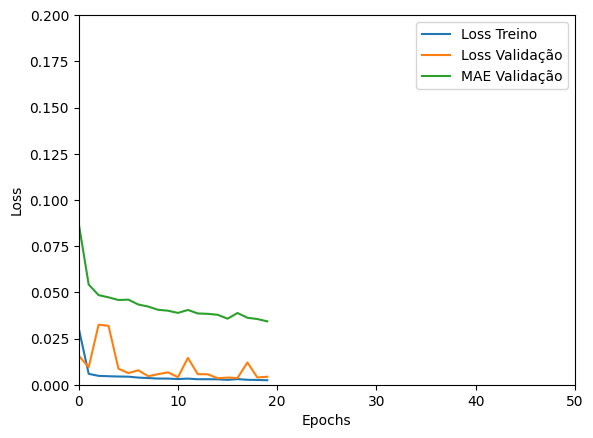

Tempo do auto treino: 0:01:38.848168
1/1 [==============================] - 1s 852ms/step
Auto Treinando EURBRL=X
Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 6
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 65, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Model: "sequential_3"
_________________________________________________________________
 Layer (type)       

None

Epoch 1/50
264/264 [==============================] - 13s 29ms/step - loss: 0.0287 - mae: 0.0862 - mse: 0.0287 - val_loss: 0.0184 - val_mae: 0.1100 - val_mse: 0.0184
Epoch 2/50
264/264 [==============================] - 8s 31ms/step - loss: 0.0061 - mae: 0.0539 - mse: 0.0061 - val_loss: 0.0074 - val_mae: 0.0699 - val_mse: 0.0074
Epoch 3/50
264/264 [==============================] - 7s 25ms/step - loss: 0.0051 - mae: 0.0497 - mse: 0.0051 - val_loss: 0.0140 - val_mae: 0.0995 - val_mse: 0.0140
Epoch 4/50
264/264 [==============================] - 8s 31ms/step - loss: 0.0046 - mae: 0.0476 - mse: 0.0046 - val_loss: 0.0067 - val_mae: 0.0660 - val_mse: 0.0067
Epoch 5/50
264/264 [==============================] - 7s 25ms/step - loss: 0.0046 - mae: 0.0475 - mse: 0.0046 - val_loss: 0.0098 - val_mae: 0.0815 - val_mse: 0.0098
Epoch 6/50
264/264 [==============================] - 8s 30ms/step - loss: 0.0039 - mae: 0.0442 - mse: 0.0039 - val_loss: 0.0090 - val_mae: 0.0781 - val_mse: 0.0090
Epoch 7/5

'TRAINING set. Loss = 0.0017516424413770437 , MAE = 0.028413565829396248'

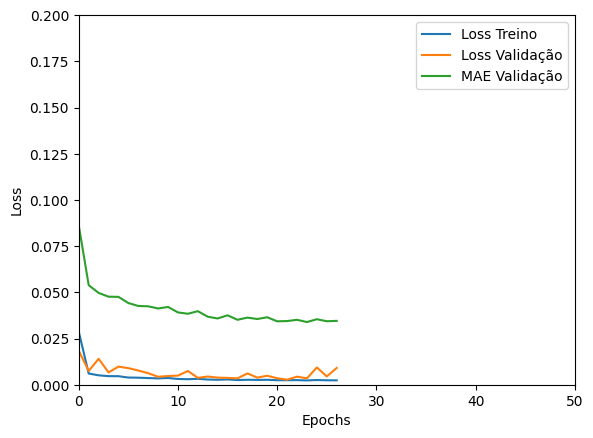

Tempo do auto treino: 0:03:29.349138
1/1 [==============================] - 1s 1s/step
Auto Treinando EURBRL=X
Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 6
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 65, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Model: "sequential_4"
_________________________________________________________________
 Layer (type)          

None

Epoch 1/50
264/264 [==============================] - 13s 32ms/step - loss: 0.0203 - mae: 0.0789 - mse: 0.0203 - val_loss: 0.0146 - val_mae: 0.1008 - val_mse: 0.0146
Epoch 2/50
264/264 [==============================] - 8s 28ms/step - loss: 0.0054 - mae: 0.0524 - mse: 0.0054 - val_loss: 0.0067 - val_mae: 0.0658 - val_mse: 0.0067
Epoch 3/50
264/264 [==============================] - 8s 31ms/step - loss: 0.0053 - mae: 0.0509 - mse: 0.0053 - val_loss: 0.0305 - val_mae: 0.1592 - val_mse: 0.0305
Epoch 4/50
264/264 [==============================] - 7s 26ms/step - loss: 0.0046 - mae: 0.0474 - mse: 0.0046 - val_loss: 0.0093 - val_mae: 0.0767 - val_mse: 0.0093
Epoch 5/50
264/264 [==============================] - 8s 32ms/step - loss: 0.0042 - mae: 0.0458 - mse: 0.0042 - val_loss: 0.0050 - val_mae: 0.0553 - val_mse: 0.0050
Epoch 6/50
264/264 [==============================] - 7s 26ms/step - loss: 0.0035 - mae: 0.0415 - mse: 0.0035 - val_loss: 0.0066 - val_mae: 0.0656 - val_mse: 0.0066
Epoch 7/5

'TRAINING set. Loss = 0.0016768701607361436 , MAE = 0.027011914178729057'

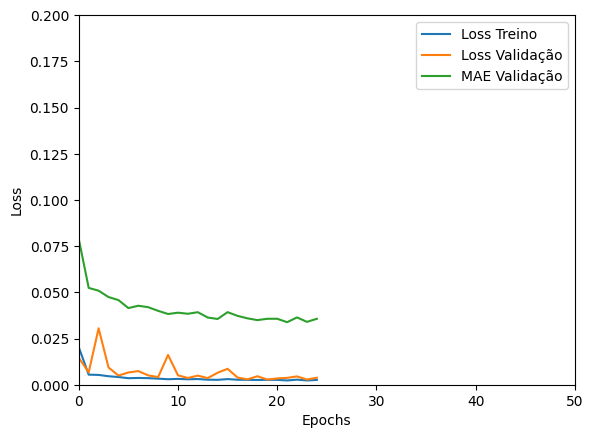

Tempo do auto treino: 0:03:30.027428
1/1 [==============================] - 1s 823ms/step
Auto Treinando USDBRL=X
Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 6
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 65, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Model: "sequential_5"
_________________________________________________________________
 Layer (type)       

None

Epoch 1/50
265/265 [==============================] - 10s 23ms/step - loss: 0.0201 - mae: 0.0724 - mse: 0.0201 - val_loss: 0.0087 - val_mae: 0.0736 - val_mse: 0.0087
Epoch 2/50
265/265 [==============================] - 5s 17ms/step - loss: 0.0042 - mae: 0.0451 - mse: 0.0042 - val_loss: 0.0092 - val_mae: 0.0791 - val_mse: 0.0092
Epoch 3/50
265/265 [==============================] - 4s 15ms/step - loss: 0.0042 - mae: 0.0448 - mse: 0.0042 - val_loss: 0.0137 - val_mae: 0.1000 - val_mse: 0.0137
Epoch 4/50
265/265 [==============================] - 5s 18ms/step - loss: 0.0037 - mae: 0.0429 - mse: 0.0037 - val_loss: 0.0077 - val_mae: 0.0715 - val_mse: 0.0077
Epoch 5/50
265/265 [==============================] - 5s 17ms/step - loss: 0.0038 - mae: 0.0434 - mse: 0.0038 - val_loss: 0.0044 - val_mae: 0.0540 - val_mse: 0.0044
Epoch 6/50
265/265 [==============================] - 4s 16ms/step - loss: 0.0032 - mae: 0.0398 - mse: 0.0032 - val_loss: 0.0045 - val_mae: 0.0549 - val_mse: 0.0045
Epoch 7/5

'TRAINING set. Loss = 0.0029018560890108347 , MAE = 0.04341777414083481'

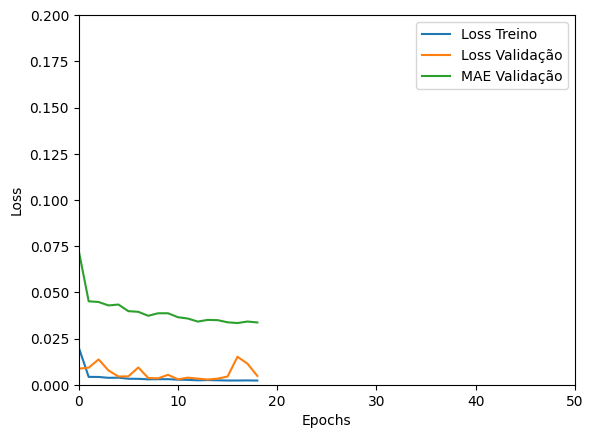

Tempo do auto treino: 0:01:35.785219


1/1 [==============================] - 1s 820ms/step
Auto Treinando USDBRL=X
Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 6
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 65, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Pa

None

Epoch 1/50
265/265 [==============================] - 11s 25ms/step - loss: 0.0254 - mae: 0.0813 - mse: 0.0254 - val_loss: 0.0147 - val_mae: 0.1002 - val_mse: 0.0147
Epoch 2/50
265/265 [==============================] - 4s 16ms/step - loss: 0.0043 - mae: 0.0462 - mse: 0.0043 - val_loss: 0.0061 - val_mae: 0.0635 - val_mse: 0.0061
Epoch 3/50
265/265 [==============================] - 4s 17ms/step - loss: 0.0040 - mae: 0.0444 - mse: 0.0040 - val_loss: 0.0049 - val_mae: 0.0572 - val_mse: 0.0049
Epoch 4/50
265/265 [==============================] - 6s 22ms/step - loss: 0.0039 - mae: 0.0436 - mse: 0.0039 - val_loss: 0.0047 - val_mae: 0.0559 - val_mse: 0.0047
Epoch 5/50
265/265 [==============================] - 4s 16ms/step - loss: 0.0036 - mae: 0.0422 - mse: 0.0036 - val_loss: 0.0047 - val_mae: 0.0545 - val_mse: 0.0047
Epoch 6/50
265/265 [==============================] - 4s 16ms/step - loss: 0.0035 - mae: 0.0415 - mse: 0.0035 - val_loss: 0.0039 - val_mae: 0.0508 - val_mse: 0.0039
Epoch 7/5

'TRAINING set. Loss = 0.0023823825176805258 , MAE = 0.03331827372312546'

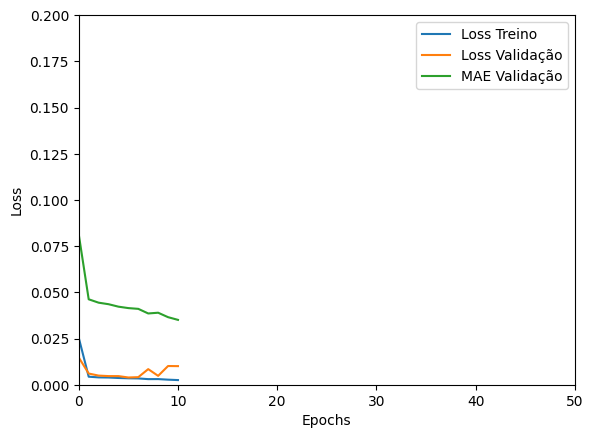

Tempo do auto treino: 0:01:01.211364


1/1 [==============================] - 1s 810ms/step
Auto Treinando USDBRL=X
Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 6
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 65, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Pa

None

Epoch 1/50
264/264 [==============================] - 13s 29ms/step - loss: 0.0218 - mae: 0.0790 - mse: 0.0218 - val_loss: 0.0103 - val_mae: 0.0845 - val_mse: 0.0103
Epoch 2/50
264/264 [==============================] - 8s 32ms/step - loss: 0.0047 - mae: 0.0472 - mse: 0.0047 - val_loss: 0.0130 - val_mae: 0.0939 - val_mse: 0.0130
Epoch 3/50
264/264 [==============================] - 7s 25ms/step - loss: 0.0041 - mae: 0.0443 - mse: 0.0041 - val_loss: 0.0101 - val_mae: 0.0837 - val_mse: 0.0101
Epoch 4/50
264/264 [==============================] - 9s 32ms/step - loss: 0.0040 - mae: 0.0443 - mse: 0.0040 - val_loss: 0.0059 - val_mae: 0.0607 - val_mse: 0.0059
Epoch 5/50
264/264 [==============================] - 7s 26ms/step - loss: 0.0034 - mae: 0.0406 - mse: 0.0034 - val_loss: 0.0039 - val_mae: 0.0507 - val_mse: 0.0039
Epoch 6/50
264/264 [==============================] - 8s 29ms/step - loss: 0.0030 - mae: 0.0374 - mse: 0.0030 - val_loss: 0.0118 - val_mae: 0.0942 - val_mse: 0.0118
Epoch 7/5

'TRAINING set. Loss = 0.001856215880252421 , MAE = 0.028239592909812927'

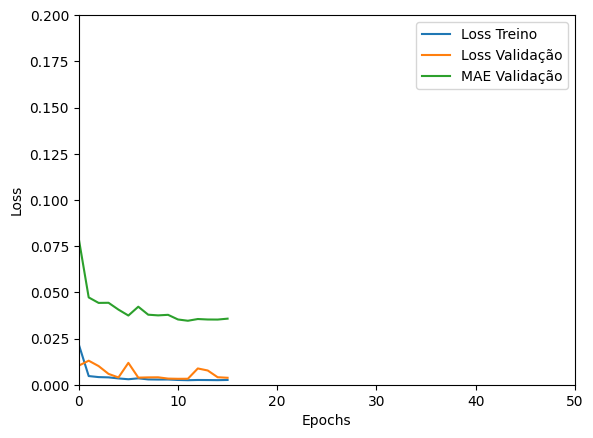

Tempo do auto treino: 0:02:29.415304
1/1 [==============================] - 1s 839ms/step
Auto Treinando USDBRL=X
Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 6
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 65, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Model: "sequential_8"
_________________________________________________________________
 Layer (type)       

None

Epoch 1/50
264/264 [==============================] - 15s 32ms/step - loss: 0.0285 - mae: 0.0866 - mse: 0.0285 - val_loss: 0.0375 - val_mae: 0.1765 - val_mse: 0.0375
Epoch 2/50
264/264 [==============================] - 8s 30ms/step - loss: 0.0047 - mae: 0.0474 - mse: 0.0047 - val_loss: 0.0135 - val_mae: 0.0982 - val_mse: 0.0135
Epoch 3/50
264/264 [==============================] - 8s 30ms/step - loss: 0.0044 - mae: 0.0463 - mse: 0.0044 - val_loss: 0.0058 - val_mae: 0.0619 - val_mse: 0.0058
Epoch 4/50
264/264 [==============================] - 7s 28ms/step - loss: 0.0035 - mae: 0.0415 - mse: 0.0035 - val_loss: 0.0109 - val_mae: 0.0889 - val_mse: 0.0109
Epoch 5/50
264/264 [==============================] - 8s 31ms/step - loss: 0.0034 - mae: 0.0407 - mse: 0.0034 - val_loss: 0.0099 - val_mae: 0.0811 - val_mse: 0.0099
Epoch 6/50
264/264 [==============================] - 7s 27ms/step - loss: 0.0031 - mae: 0.0393 - mse: 0.0031 - val_loss: 0.0041 - val_mae: 0.0516 - val_mse: 0.0041
Epoch 7/5

'TRAINING set. Loss = 0.002016420941799879 , MAE = 0.03420759364962578'

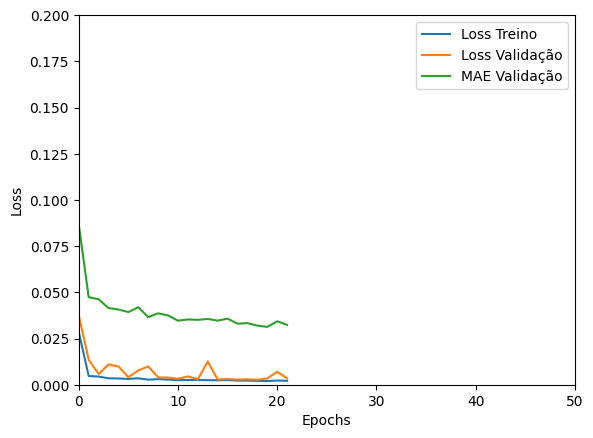

Tempo do auto treino: 0:03:31.037475
1/1 [==============================] - 1s 828ms/step

Tempo TOTAL do auto treino: 0:55:24.280235


In [14]:
model_type_str = 'AUTO'

inittime_auto = datetime.now()
for stock in arr_acoes_hyperparams:
  for timesteps in timesteps_hyper:
    scaler, X_train, X_test, y_train, y_test = preprocess(df, stock, timesteps, len(data_teste))
    for batch_size in batch_hyper:
      inittime = datetime.now()
      print(f"Auto Treinando {stock}")
      m, h = auto_model_type(X_train, y_train, batch_size, epochs)
      endtime = datetime.now()
      print(f'Tempo do auto treino: {endtime-inittime}' )
      y_pred = m.predict(X_test)
      score = m.evaluate(X_test, y_test, verbose=0)

      optimizer, num_layers, unit, activation, dropout_rate = get_model_info(m)
      mod_cfg_res = {'model_type': model_type_str, 'stock':stock, 'num_layers':num_layers ,'unit':unit,
                     'optimizer':optimizer, 'activation':activation,
                     'dropout_rate':dropout_rate, "mae":score[1], "mse":score[2],
                     "batch_size":batch_size, "timesteps":timesteps}

      all_results = all_results.append(mod_cfg_res, ignore_index=True)

      # save the model architecture to a JSON string
      fprefix = f"{stock}_{model_type_str}_{num_layers}_{unit}_{activation}_{optimizer}_{dropout_rate}_{batch_size}_{timesteps}"
      with open(f"{fprefix}.json", "w") as json_file:
        model_json = m.to_json()
        json_file.write(model_json)
        # serialize weights to HDF5
        m.save_weights(f"{fprefix}.h5")

      del m, h

endtime_auto = datetime.now()
print(f'\nTempo TOTAL do auto treino: {endtime_auto-inittime_auto}' )

### MANUAL Tunning

Para o tunning manual foram testadas os modelos de RNN abaixo, submetidos ao mesmo dataset e a variação em paramêtros.


Funções

In [15]:
def train_model(mod, optimizer, X, y, batch_size, patience, epochs):

  opt_obj = tf.keras.optimizers.Adam()
  if optimizer == "adam":
    pass
  elif optimizer == "sgd":
    opt_obj = tf.keras.optimizers.SGD()

  mod.compile(loss=tf.losses.MeanSquaredError(),optimizer=opt_obj, metrics=metrics_used)

  display.display(mod.summary())
  hist = mod.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[get_early_stopping(patience)], verbose=0,
                  shuffle=False)

  loss_metric_train = mod.evaluate(X, y, verbose=0, batch_size=batch_size, use_multiprocessing=True)
  display.display( 'TRAINING set. Loss = {} , MAE = {}'.format(loss_metric_train[0], loss_metric_train[1]))

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(hist.history['loss'], label="Loss Treino")
  plt.plot(hist.history['val_loss'], label="Loss Validação")
  plt.plot(hist.history['val_mae'], label='MAE Validação')
  plt.ylim([0.0, 0.2])
  plt.xlim([0.0, epochs])
  plt.legend()
  plt.show()

  return mod, hist


def model_type(mod_type, unit, optimizer, timesteps, X, y, epochs=60, batch_size=32, patience=5):
  func = globals()[mod_type]
  return func(unit, optimizer, timesteps, X, y, epochs, batch_size, patience)


def LSTM_v1(unit, optimizer, timesteps, X, y, epochs, batch_size, patience):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), return_sequences=False))
    mod.add(Dense(1, activation='linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist


def LSTM_v2(unit, optimizer, timesteps, X, y, epochs, batch_size, patience, l2_reg=0.001):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), kernel_regularizer=l2(l2_reg),
                 return_sequences=False))
    mod.add(Dense(1, activation='linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist


def LSTM_v3(unit, optimizer, timesteps, X, y, epochs, batch_size, patience, dropout_rate=0.3, l2_reg=0.001):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), kernel_regularizer=l2(l2_reg),
                 return_sequences=False))
    mod.add(Dropout(dropout_rate))
    mod.add(Dense(1, activation='linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist


def LSTM_v4(unit, optimizer, timesteps, X, y, epochs, batch_size, patience, dropout_rate=0.3):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), return_sequences=True))
    mod.add(Dropout(0.1))
    mod.add(LSTM(int(unit/4), activation='relu', return_sequences=False ))
    mod.add(Dropout(0.1))
    mod.add(Dense(1, activation='linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist


def CNN_v1(unit, optimizer, timesteps, X, y, epochs, batch_size, patience):

  mod = Sequential()
  mod.add(Conv1D(filters=unit, kernel_size=2, activation='relu', input_shape=(1,1)))
  # mod.add(BatchNormalization())
  mod.add(Activation("relu"))
  # mod.add(MaxPooling1D(pool_size=3))
  mod.add(Flatten())
  mod.add(Dense(1, activation='linear'))

  mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)
  return mod, hist

Hiperparametrização manual e treinamento

Treinando EURBRL=X com LSTM_v1, opt=adam, units=32, batch=8, timesteps=10
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 32)                4352      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.07305332273244858 , MAE = 0.2191661149263382'

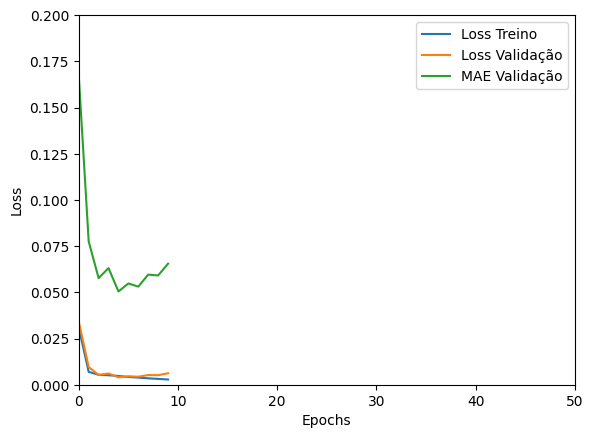

Tempo de treino: 0:00:35.195961
1/1 [==============================] - 0s 276ms/step
Treinando EURBRL=X com LSTM_v1, opt=adam, units=32, batch=16, timesteps=10
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 32)                4352      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.024322738870978355 , MAE = 0.13197216391563416'

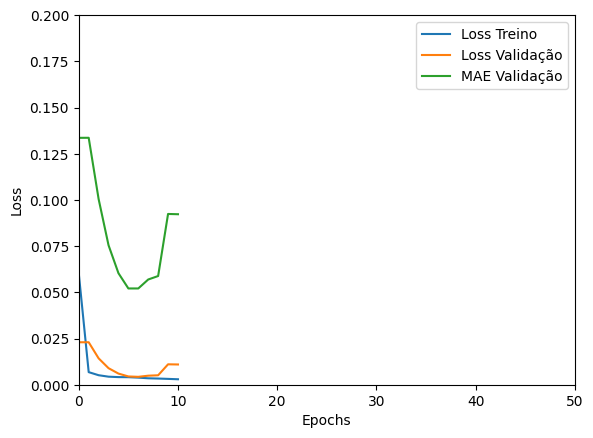

Tempo de treino: 0:00:23.875742
1/1 [==============================] - 0s 179ms/step
Treinando EURBRL=X com LSTM_v1, opt=adam, units=64, batch=8, timesteps=10
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 64)                16896     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.09170769900083542 , MAE = 0.25020575523376465'

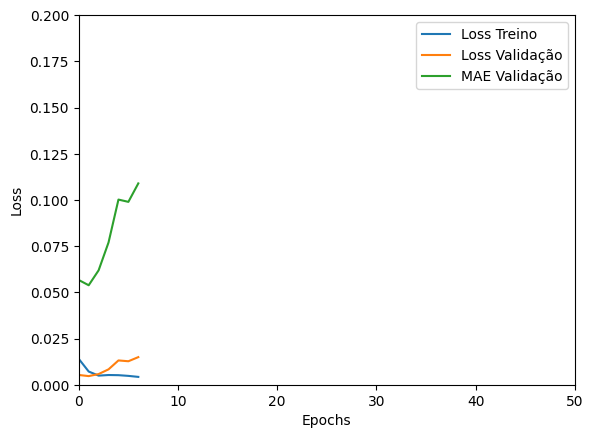

Tempo de treino: 0:00:44.651689
1/1 [==============================] - 0s 176ms/step
Treinando EURBRL=X com LSTM_v1, opt=adam, units=64, batch=16, timesteps=10
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                16896     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.05040700361132622 , MAE = 0.1803581714630127'

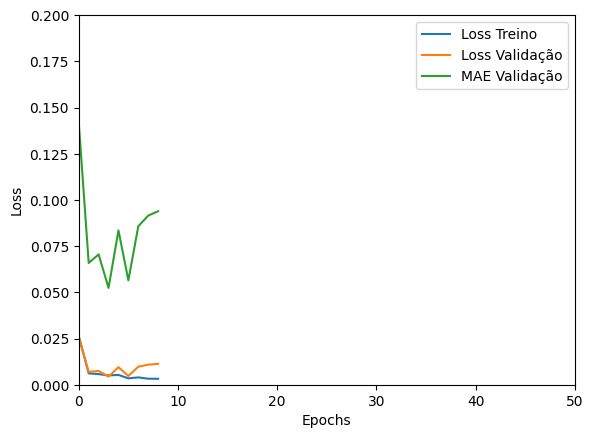

Tempo de treino: 0:00:23.385474
1/1 [==============================] - 0s 188ms/step
Treinando EURBRL=X com LSTM_v1, opt=sgd, units=32, batch=8, timesteps=10
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 32)                4352      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.00883218552917242 , MAE = 0.07808336615562439'

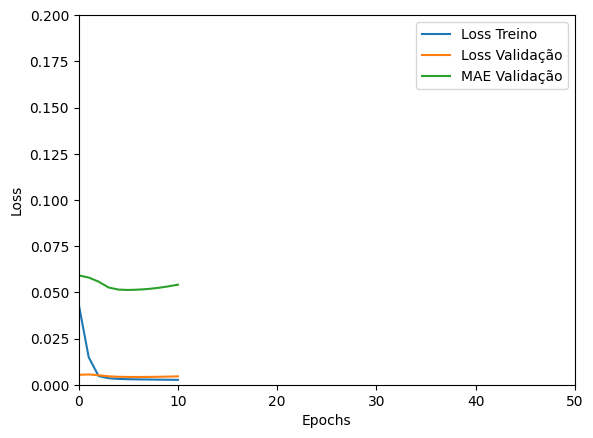

Tempo de treino: 0:00:45.432210
1/1 [==============================] - 0s 206ms/step
Treinando EURBRL=X com LSTM_v1, opt=sgd, units=32, batch=16, timesteps=10
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 32)                4352      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.007361449766904116 , MAE = 0.06655622273683548'

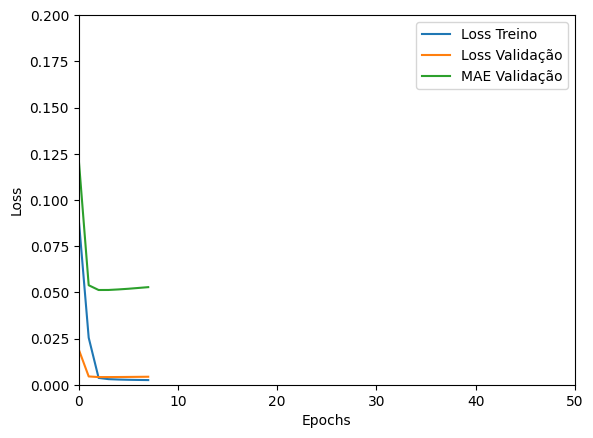

Tempo de treino: 0:00:16.833576
1/1 [==============================] - 0s 283ms/step
Treinando EURBRL=X com LSTM_v1, opt=sgd, units=64, batch=8, timesteps=10
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 64)                16896     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.01490925531834364 , MAE = 0.09712263941764832'

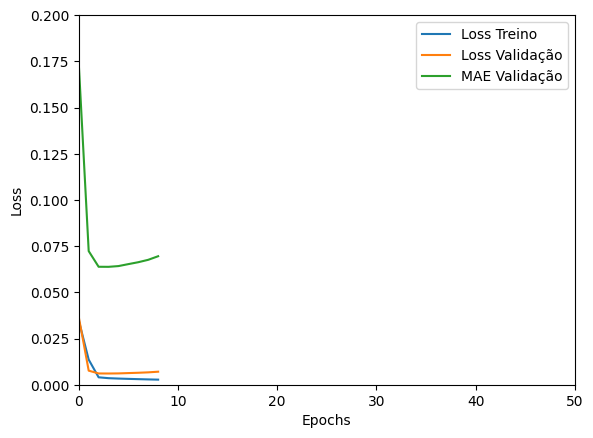

Tempo de treino: 0:00:35.090192
1/1 [==============================] - 0s 204ms/step
Treinando EURBRL=X com LSTM_v1, opt=sgd, units=64, batch=16, timesteps=10
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 64)                16896     
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.0031303472351282835 , MAE = 0.0429781973361969'

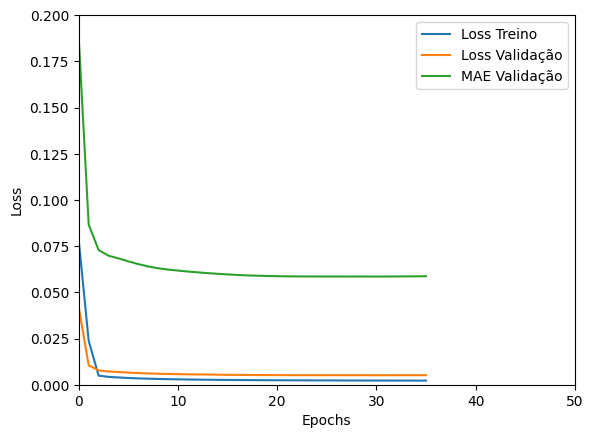

Tempo de treino: 0:01:25.146971
1/1 [==============================] - 0s 190ms/step
Treinando EURBRL=X com LSTM_v2, opt=adam, units=32, batch=8, timesteps=10
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 32)                4352      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.0527612529695034 , MAE = 0.19298845529556274'

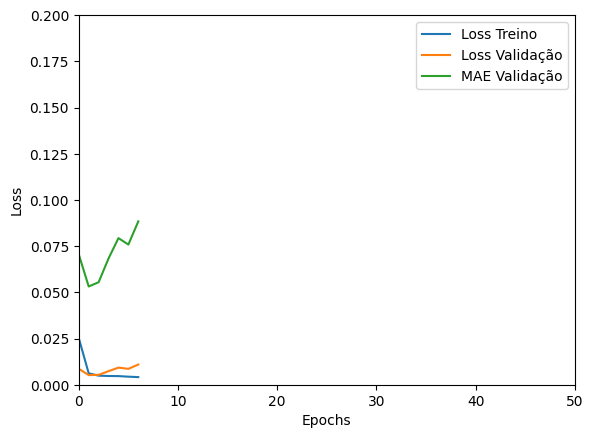

Tempo de treino: 0:00:44.363716
1/1 [==============================] - 0s 183ms/step
Treinando EURBRL=X com LSTM_v2, opt=adam, units=32, batch=16, timesteps=10
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 32)                4352      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.02900518849492073 , MAE = 0.1487749069929123'

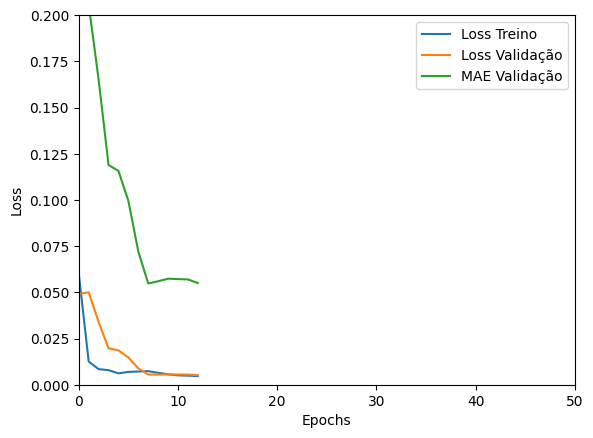

Tempo de treino: 0:00:44.410895
1/1 [==============================] - 0s 213ms/step
Treinando EURBRL=X com LSTM_v2, opt=adam, units=64, batch=8, timesteps=10
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 64)                16896     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.09890799224376678 , MAE = 0.259809672832489'

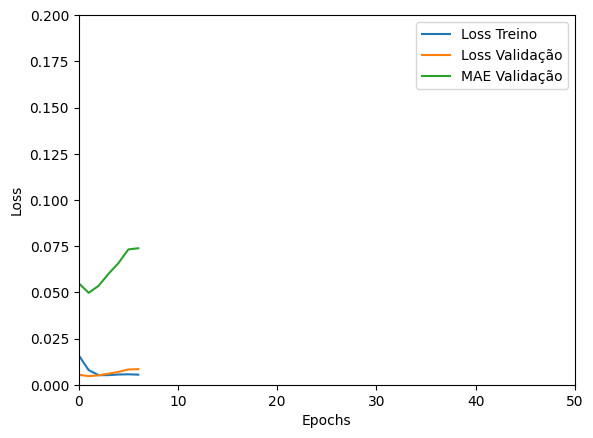

Tempo de treino: 0:00:29.940897
1/1 [==============================] - 0s 220ms/step
Treinando EURBRL=X com LSTM_v2, opt=adam, units=64, batch=16, timesteps=10
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 64)                16896     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.049676939845085144 , MAE = 0.18462707102298737'

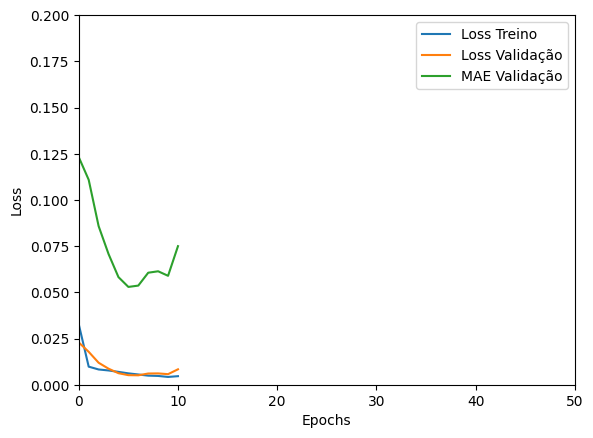

Tempo de treino: 0:00:25.793132
1/1 [==============================] - 0s 191ms/step
Treinando EURBRL=X com LSTM_v2, opt=sgd, units=32, batch=8, timesteps=10
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 32)                4352      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.01321944035589695 , MAE = 0.08897159993648529'

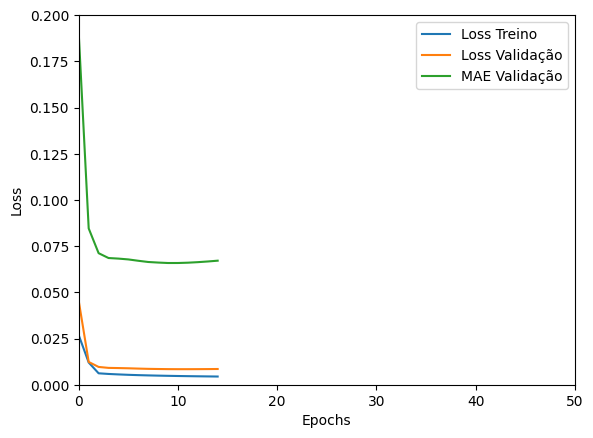

Tempo de treino: 0:01:26.454055
1/1 [==============================] - 0s 188ms/step
Treinando EURBRL=X com LSTM_v2, opt=sgd, units=32, batch=16, timesteps=10
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 32)                4352      
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.007061478216201067 , MAE = 0.05748673155903816'

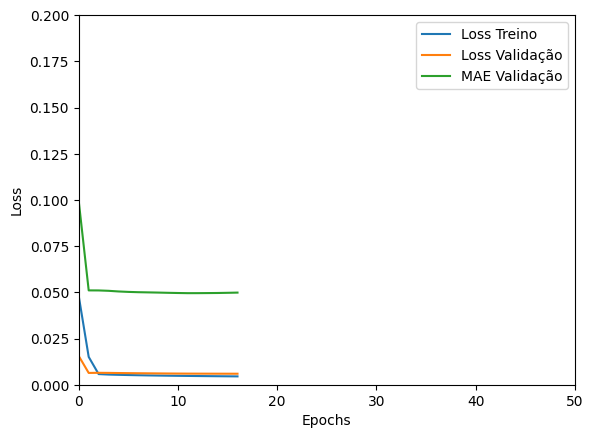

Tempo de treino: 0:00:44.119204
1/1 [==============================] - 0s 195ms/step
Treinando EURBRL=X com LSTM_v2, opt=sgd, units=64, batch=8, timesteps=10
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 64)                16896     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.01273359265178442 , MAE = 0.08463750779628754'

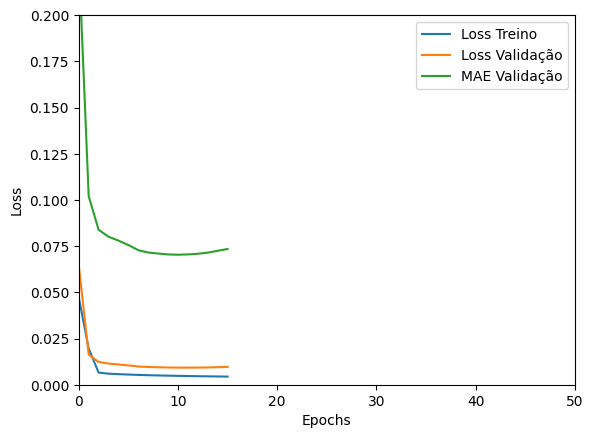

Tempo de treino: 0:01:25.091027
1/1 [==============================] - 0s 197ms/step
Treinando EURBRL=X com LSTM_v2, opt=sgd, units=64, batch=16, timesteps=10
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 64)                16896     
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.007844364270567894 , MAE = 0.06009224057197571'

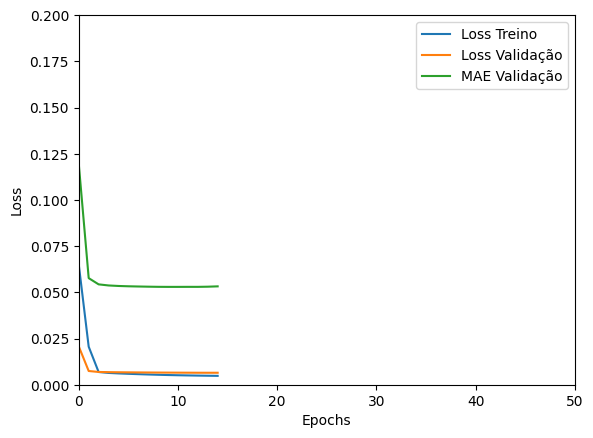

Tempo de treino: 0:00:31.334875
1/1 [==============================] - 0s 196ms/step
Treinando EURBRL=X com LSTM_v1, opt=adam, units=32, batch=8, timesteps=20
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 32)                4352      
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

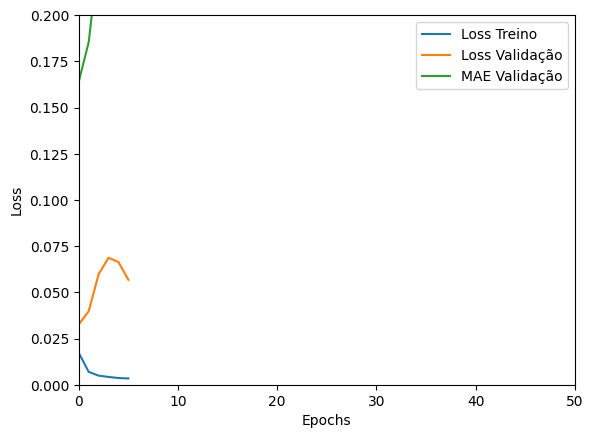

Tempo de treino: 0:00:45.738579
1/1 [==============================] - 0s 182ms/step
Treinando EURBRL=X com LSTM_v1, opt=adam, units=32, batch=16, timesteps=20
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 32)                4352      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.02419251576066017 , MAE = 0.12653955817222595'

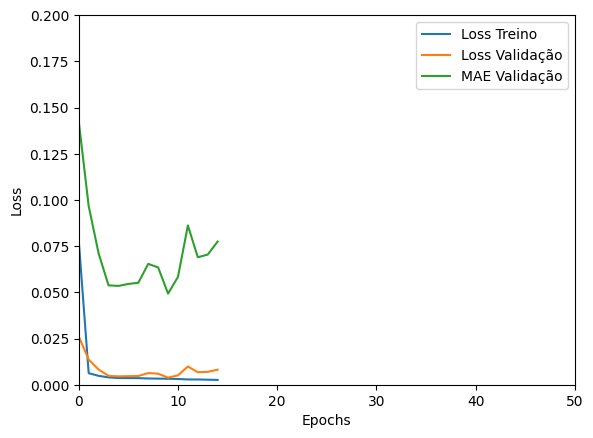

Tempo de treino: 0:01:26.634708
1/1 [==============================] - 0s 333ms/step
Treinando EURBRL=X com LSTM_v1, opt=adam, units=64, batch=8, timesteps=20
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 64)                16896     
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.09295885264873505 , MAE = 0.25979575514793396'

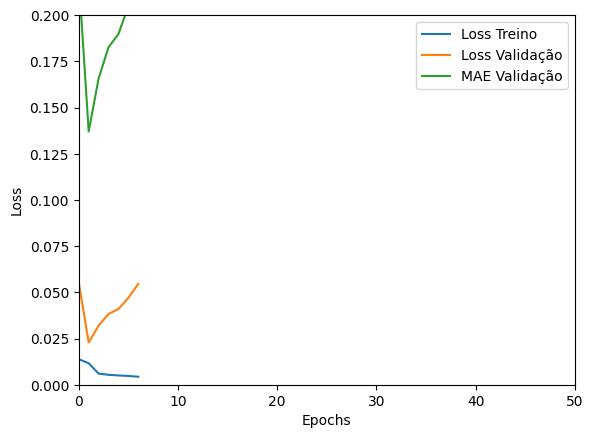

Tempo de treino: 0:00:45.519389
1/1 [==============================] - 0s 186ms/step
Treinando EURBRL=X com LSTM_v1, opt=adam, units=64, batch=16, timesteps=20
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 64)                16896     
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.046226803213357925 , MAE = 0.17966972291469574'

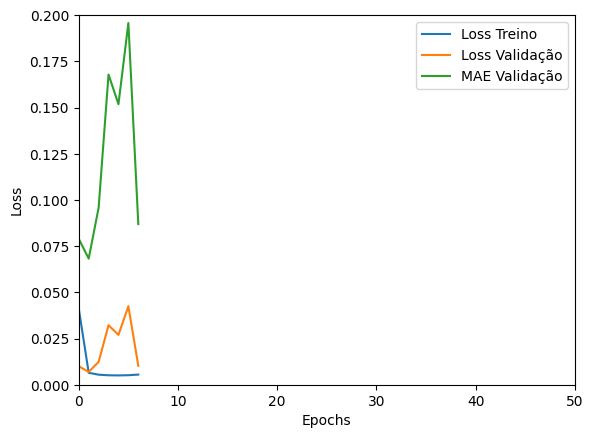

Tempo de treino: 0:00:25.849726
1/1 [==============================] - 0s 194ms/step
Treinando EURBRL=X com LSTM_v1, opt=sgd, units=32, batch=8, timesteps=20
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 32)                4352      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.005469484254717827 , MAE = 0.062059760093688965'

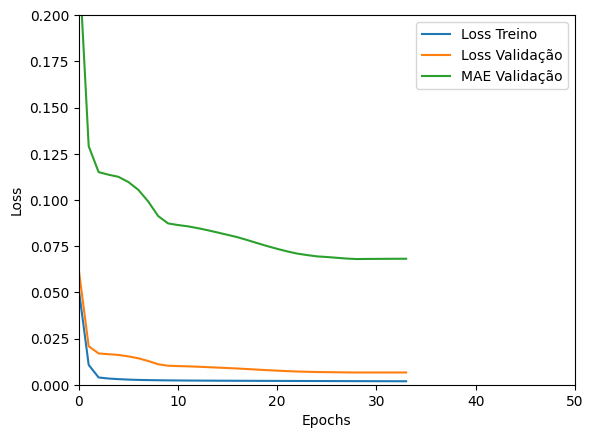

Tempo de treino: 0:03:26.207875
1/1 [==============================] - 0s 326ms/step
Treinando EURBRL=X com LSTM_v1, opt=sgd, units=32, batch=16, timesteps=20
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 32)                4352      
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.010483797639608383 , MAE = 0.08450891077518463'

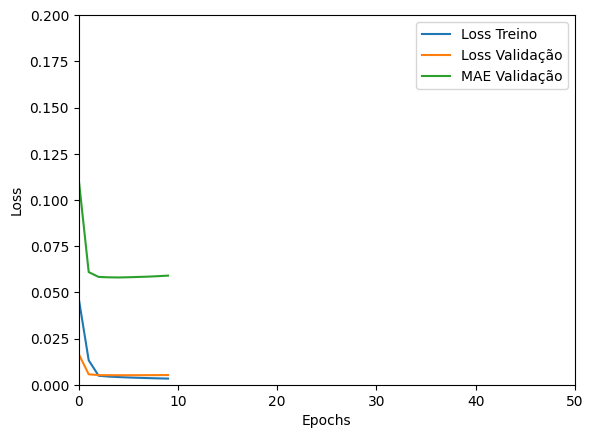

Tempo de treino: 0:00:30.188575
1/1 [==============================] - 0s 208ms/step
Treinando EURBRL=X com LSTM_v1, opt=sgd, units=64, batch=8, timesteps=20
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 64)                16896     
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.005800775717943907 , MAE = 0.06411758065223694'

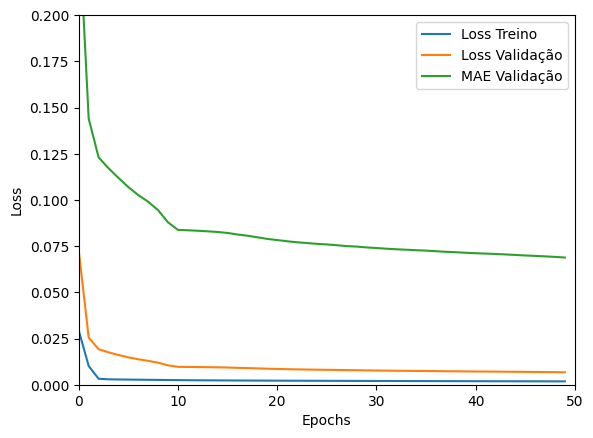

Tempo de treino: 0:05:26.099212
1/1 [==============================] - 0s 321ms/step
Treinando EURBRL=X com LSTM_v1, opt=sgd, units=64, batch=16, timesteps=20
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 64)                16896     
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.0129388477653265 , MAE = 0.09355217218399048'

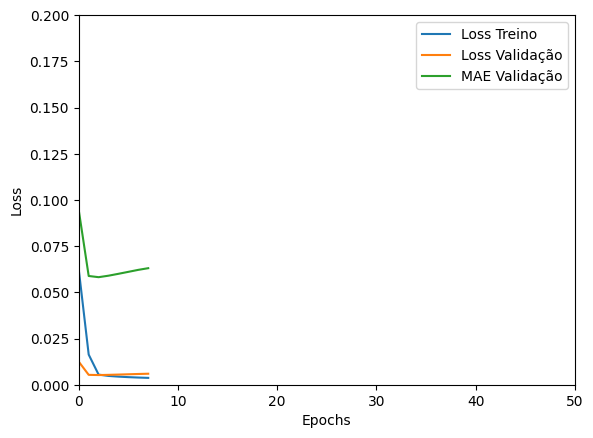

Tempo de treino: 0:00:30.116618
1/1 [==============================] - 0s 236ms/step
Treinando EURBRL=X com LSTM_v2, opt=adam, units=32, batch=8, timesteps=20
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 32)                4352      
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.08094722777605057 , MAE = 0.23411621153354645'

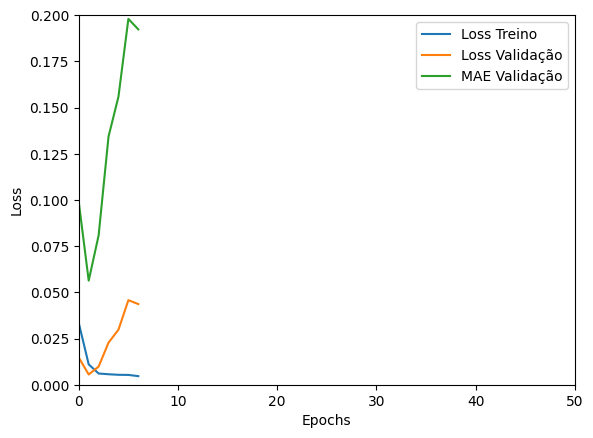

Tempo de treino: 0:00:46.080926
1/1 [==============================] - 0s 198ms/step
Treinando EURBRL=X com LSTM_v2, opt=adam, units=32, batch=16, timesteps=20
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 32)                4352      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.030050532892346382 , MAE = 0.140985906124115'

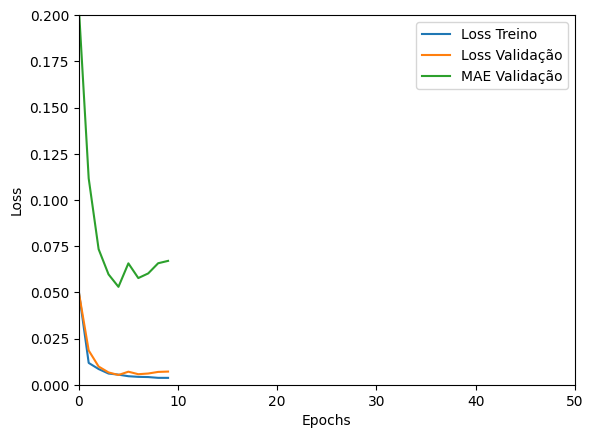

Tempo de treino: 0:00:45.056197
1/1 [==============================] - 0s 212ms/step
Treinando EURBRL=X com LSTM_v2, opt=adam, units=64, batch=8, timesteps=20
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 64)                16896     
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.0976816862821579 , MAE = 0.2688997983932495'

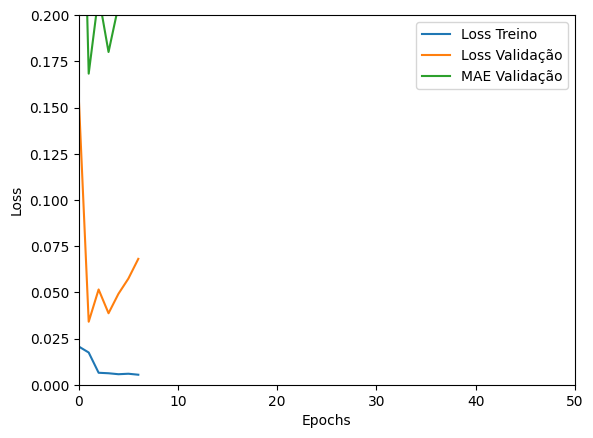

Tempo de treino: 0:01:26.904101
1/1 [==============================] - 0s 288ms/step
Treinando EURBRL=X com LSTM_v2, opt=adam, units=64, batch=16, timesteps=20
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 64)                16896     
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.07958924770355225 , MAE = 0.2305358201265335'

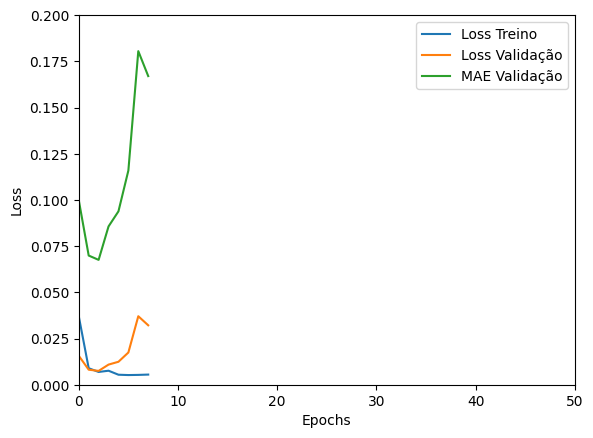

Tempo de treino: 0:00:28.772018
1/1 [==============================] - 0s 192ms/step
Treinando EURBRL=X com LSTM_v2, opt=sgd, units=32, batch=8, timesteps=20
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 32)                4352      
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.015705754980444908 , MAE = 0.09973806142807007'

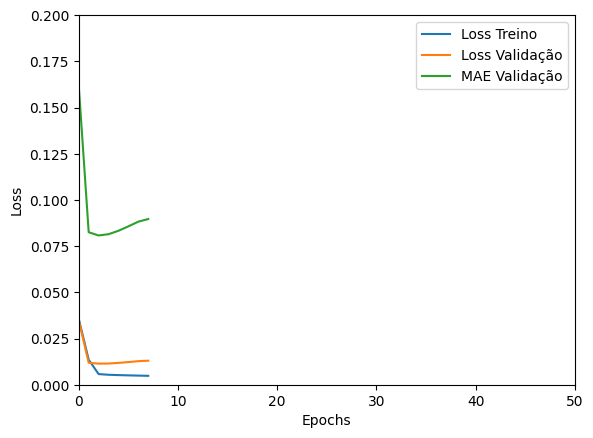

Tempo de treino: 0:01:26.423800
1/1 [==============================] - 0s 294ms/step
Treinando EURBRL=X com LSTM_v2, opt=sgd, units=32, batch=16, timesteps=20
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 32)                4352      
                                                                 
 dense_38 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.01179296150803566 , MAE = 0.07947558164596558'

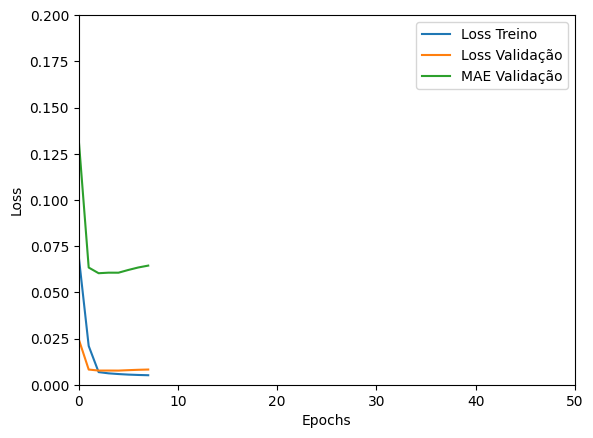

Tempo de treino: 0:00:43.851572
1/1 [==============================] - 0s 230ms/step
Treinando EURBRL=X com LSTM_v2, opt=sgd, units=64, batch=8, timesteps=20
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 64)                16896     
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.021904075518250465 , MAE = 0.11723974347114563'

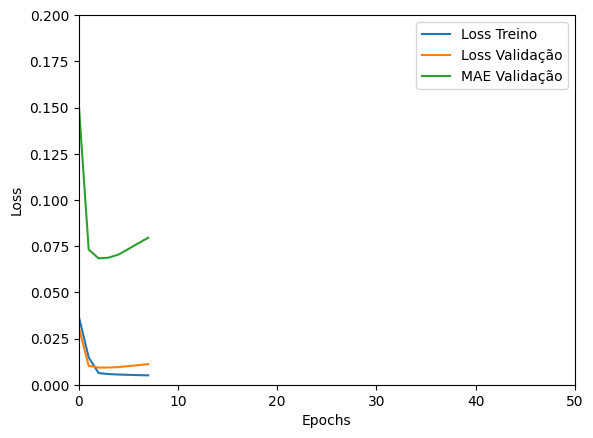

Tempo de treino: 0:00:52.911383
1/1 [==============================] - 0s 236ms/step
Treinando EURBRL=X com LSTM_v2, opt=sgd, units=64, batch=16, timesteps=20
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 64)                16896     
                                                                 
 dense_40 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.008921729400753975 , MAE = 0.0659286230802536'

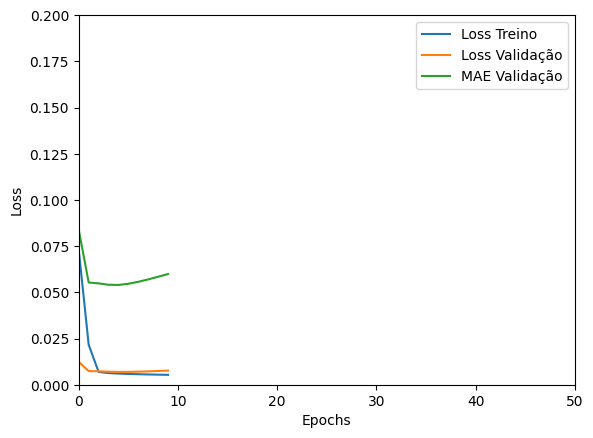

Tempo de treino: 0:00:36.330923
1/1 [==============================] - 0s 188ms/step
Treinando USDBRL=X com LSTM_v1, opt=adam, units=32, batch=8, timesteps=10
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 32)                4352      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.18323738873004913 , MAE = 0.35916247963905334'

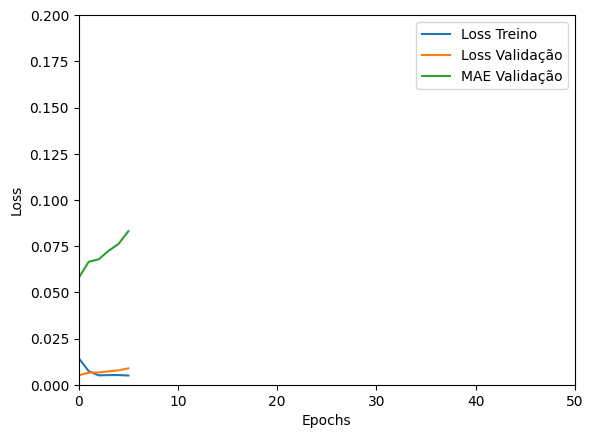

Tempo de treino: 0:00:24.371512
1/1 [==============================] - 0s 198ms/step
Treinando USDBRL=X com LSTM_v1, opt=adam, units=32, batch=16, timesteps=10
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 32)                4352      
                                                                 
 dense_42 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.04013073816895485 , MAE = 0.15995894372463226'

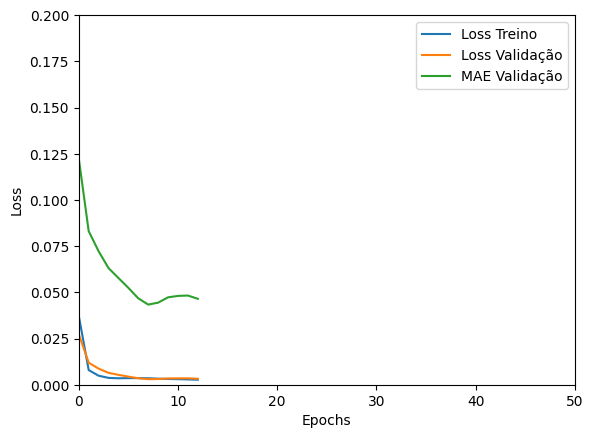

Tempo de treino: 0:00:26.193329
1/1 [==============================] - 0s 201ms/step
Treinando USDBRL=X com LSTM_v1, opt=adam, units=64, batch=8, timesteps=10
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 64)                16896     
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.1687435507774353 , MAE = 0.33523643016815186'

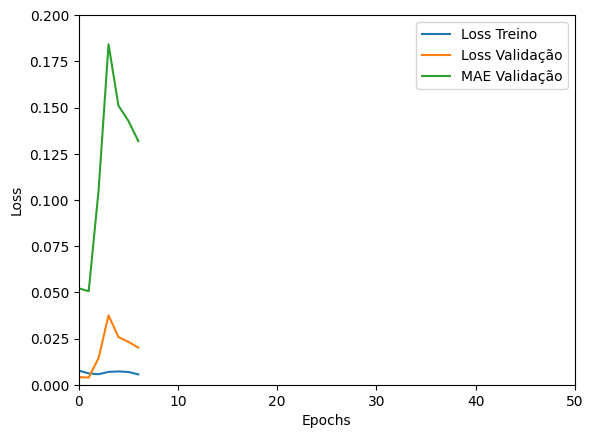

Tempo de treino: 0:00:29.087520
1/1 [==============================] - 0s 201ms/step
Treinando USDBRL=X com LSTM_v1, opt=adam, units=64, batch=16, timesteps=10
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 64)                16896     
                                                                 
 dense_44 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.06333810091018677 , MAE = 0.20559623837471008'

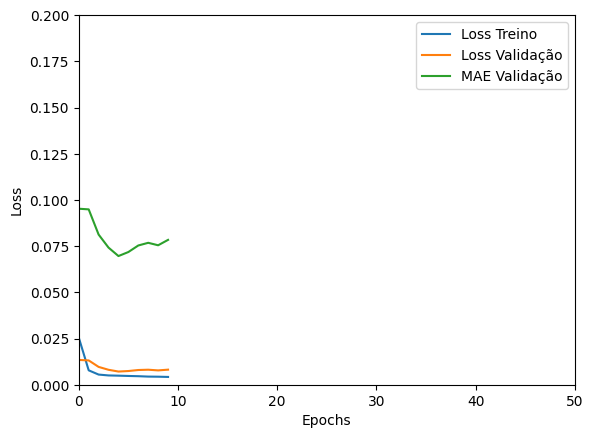

Tempo de treino: 0:00:24.016582
1/1 [==============================] - 0s 195ms/step
Treinando USDBRL=X com LSTM_v1, opt=sgd, units=32, batch=8, timesteps=10
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 32)                4352      
                                                                 
 dense_45 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.01590932160615921 , MAE = 0.10377974063158035'

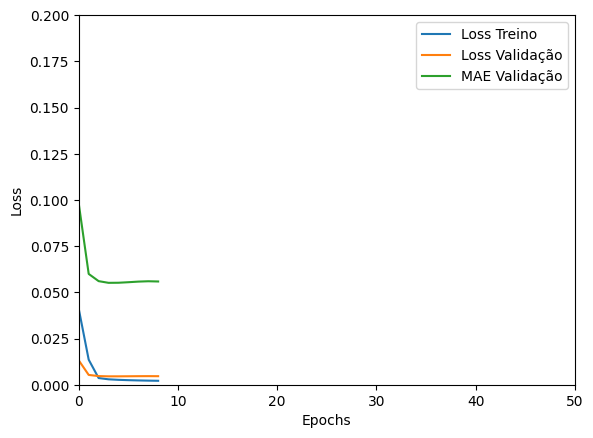

Tempo de treino: 0:00:36.683583
1/1 [==============================] - 0s 353ms/step
Treinando USDBRL=X com LSTM_v1, opt=sgd, units=32, batch=16, timesteps=10
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 32)                4352      
                                                                 
 dense_46 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.002236135769635439 , MAE = 0.03628788888454437'

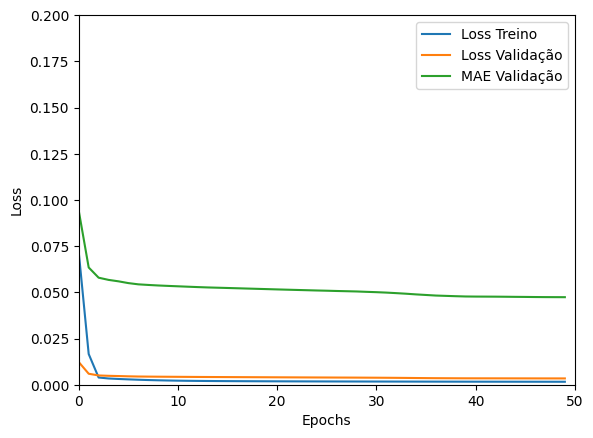

Tempo de treino: 0:02:24.796210
1/1 [==============================] - 0s 210ms/step
Treinando USDBRL=X com LSTM_v1, opt=sgd, units=64, batch=8, timesteps=10
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 64)                16896     
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.003440568223595619 , MAE = 0.048446156084537506'

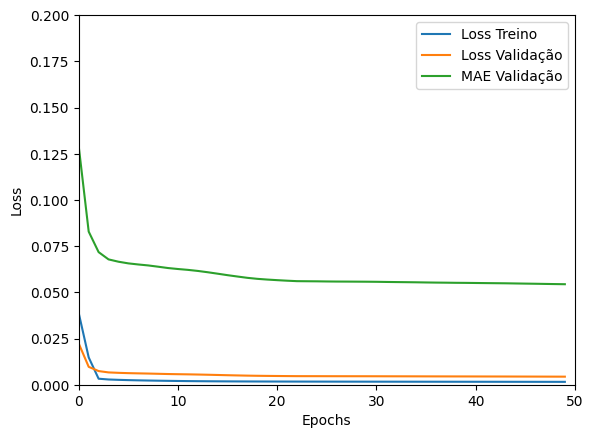

Tempo de treino: 0:03:25.871613
1/1 [==============================] - 0s 207ms/step
Treinando USDBRL=X com LSTM_v1, opt=sgd, units=64, batch=16, timesteps=10
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 64)                16896     
                                                                 
 dense_48 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.0021715944167226553 , MAE = 0.035031720995903015'

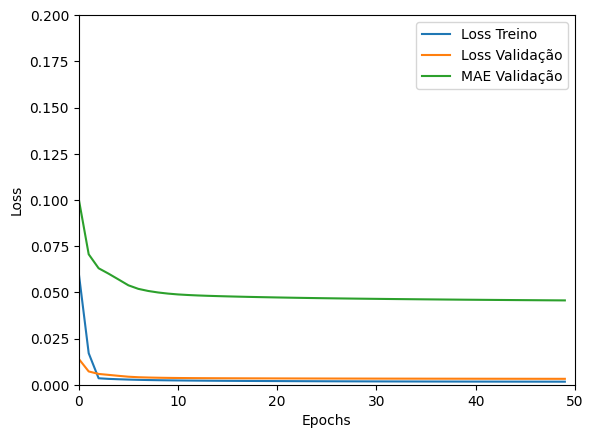

Tempo de treino: 0:01:38.190401
1/1 [==============================] - 0s 202ms/step
Treinando USDBRL=X com LSTM_v2, opt=adam, units=32, batch=8, timesteps=10
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 32)                4352      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.14966532588005066 , MAE = 0.31027698516845703'

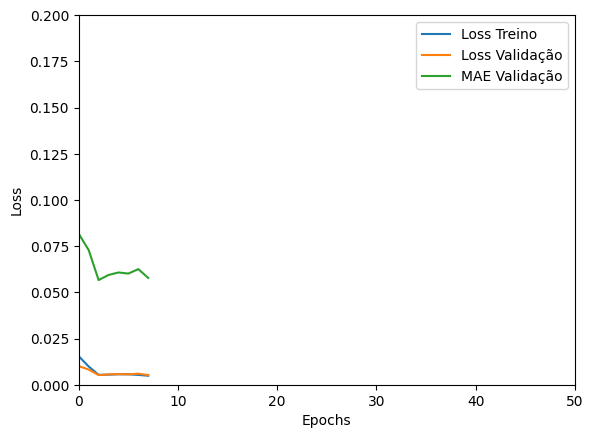

Tempo de treino: 0:00:45.846889
1/1 [==============================] - 0s 195ms/step
Treinando USDBRL=X com LSTM_v2, opt=adam, units=32, batch=16, timesteps=10
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 32)                4352      
                                                                 
 dense_50 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.04799056053161621 , MAE = 0.173473060131073'

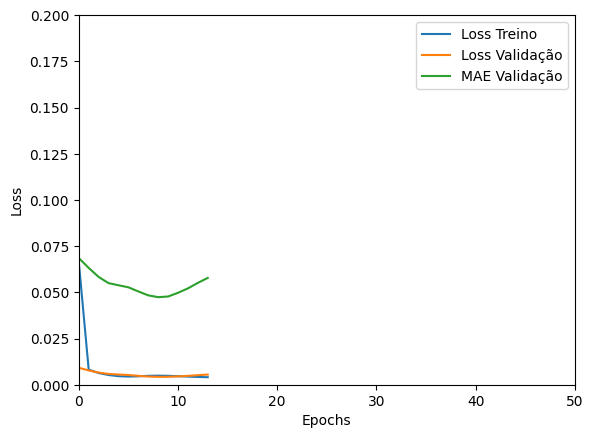

Tempo de treino: 0:00:27.270533
1/1 [==============================] - 0s 189ms/step
Treinando USDBRL=X com LSTM_v2, opt=adam, units=64, batch=8, timesteps=10
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 64)                16896     
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.2750896215438843 , MAE = 0.4531249403953552'

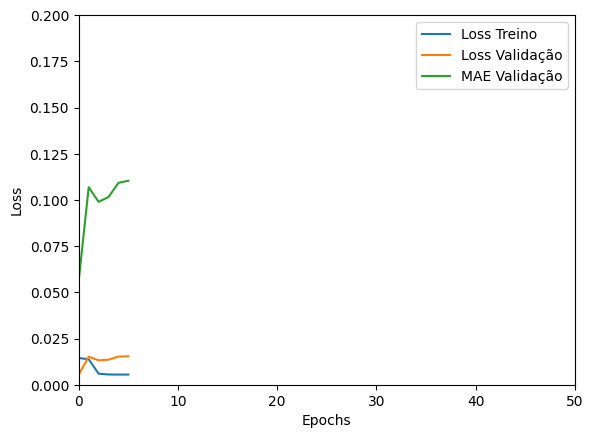

Tempo de treino: 0:00:28.036705
1/1 [==============================] - 0s 253ms/step
Treinando USDBRL=X com LSTM_v2, opt=adam, units=64, batch=16, timesteps=10
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 64)                16896     
                                                                 
 dense_52 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.04050310701131821 , MAE = 0.16104713082313538'

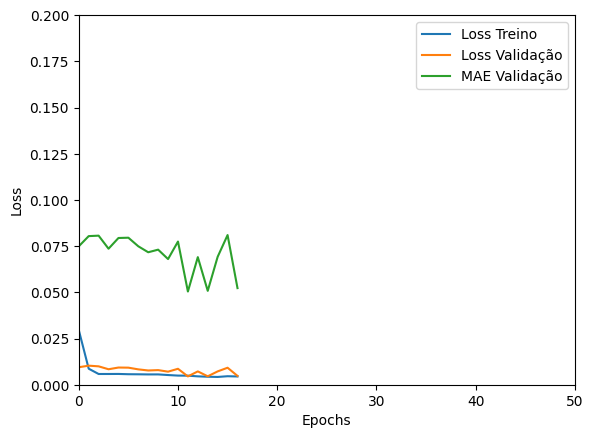

Tempo de treino: 0:00:44.254932
1/1 [==============================] - 0s 220ms/step
Treinando USDBRL=X com LSTM_v2, opt=sgd, units=32, batch=8, timesteps=10
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 32)                4352      
                                                                 
 dense_53 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.026133352890610695 , MAE = 0.12452516704797745'

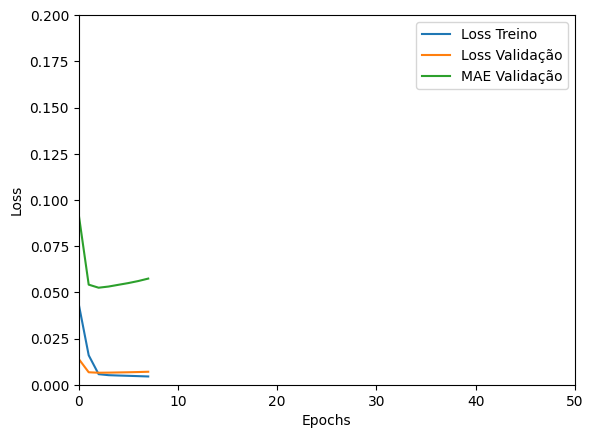

Tempo de treino: 0:00:30.977184
1/1 [==============================] - 0s 275ms/step
Treinando USDBRL=X com LSTM_v2, opt=sgd, units=32, batch=16, timesteps=10
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 32)                4352      
                                                                 
 dense_54 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.005766167771071196 , MAE = 0.04856044426560402'

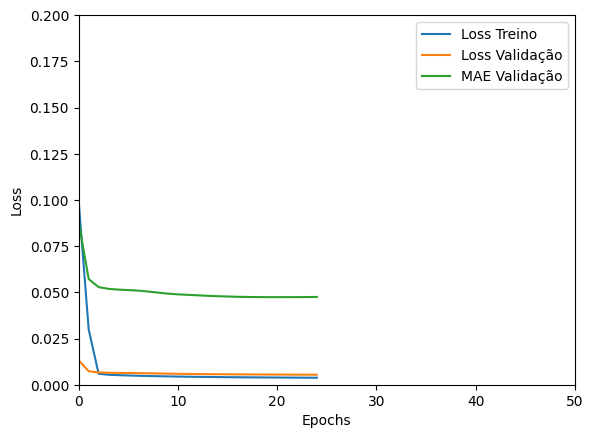

Tempo de treino: 0:00:44.393537
1/1 [==============================] - 0s 191ms/step
Treinando USDBRL=X com LSTM_v2, opt=sgd, units=64, batch=8, timesteps=10
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 64)                16896     
                                                                 
 dense_55 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.012181478552520275 , MAE = 0.08119985461235046'

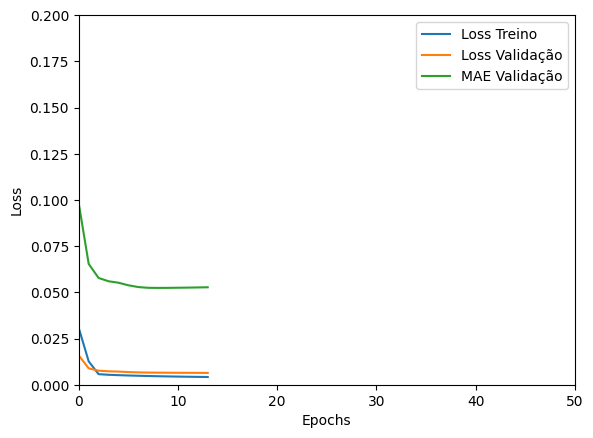

Tempo de treino: 0:00:52.986519
1/1 [==============================] - 0s 203ms/step
Treinando USDBRL=X com LSTM_v2, opt=sgd, units=64, batch=16, timesteps=10
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 64)                16896     
                                                                 
 dense_56 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.004519463982433081 , MAE = 0.043111324310302734'

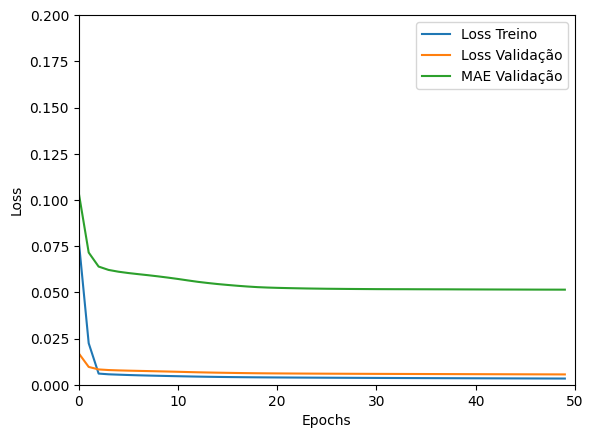

Tempo de treino: 0:02:25.189915
1/1 [==============================] - 0s 210ms/step
Treinando USDBRL=X com LSTM_v1, opt=adam, units=32, batch=8, timesteps=20
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 32)                4352      
                                                                 
 dense_57 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.13044027984142303 , MAE = 0.3250330090522766'

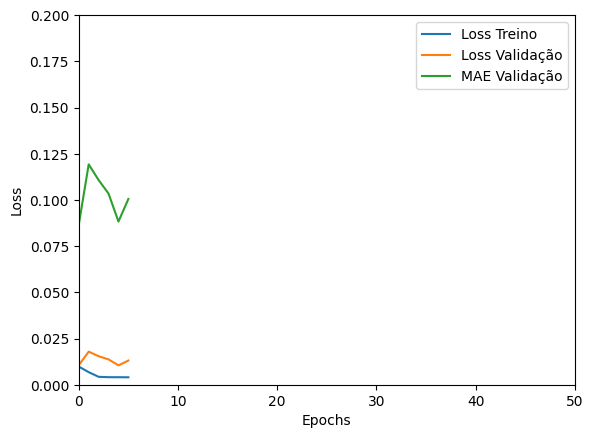

Tempo de treino: 0:00:37.209288
1/1 [==============================] - 0s 196ms/step
Treinando USDBRL=X com LSTM_v1, opt=adam, units=32, batch=16, timesteps=20
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 32)                4352      
                                                                 
 dense_58 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.02401975728571415 , MAE = 0.12569281458854675'

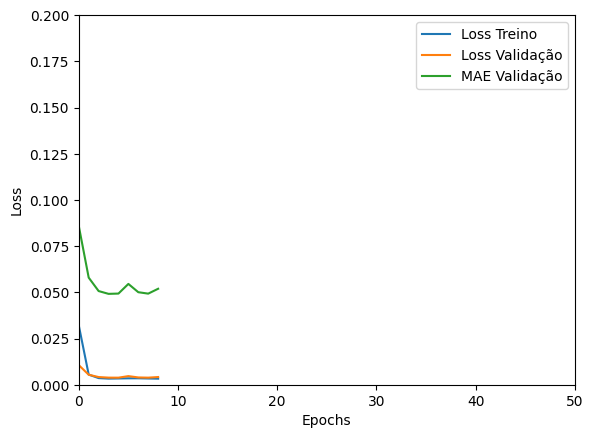

Tempo de treino: 0:00:29.906731
1/1 [==============================] - 0s 331ms/step
Treinando USDBRL=X com LSTM_v1, opt=adam, units=64, batch=8, timesteps=20
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 64)                16896     
                                                                 
 dense_59 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.1696644127368927 , MAE = 0.35132312774658203'

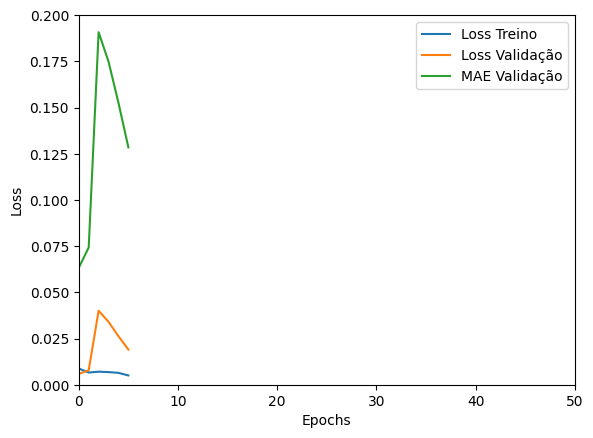

Tempo de treino: 0:00:40.470894
1/1 [==============================] - 0s 334ms/step
Treinando USDBRL=X com LSTM_v1, opt=adam, units=64, batch=16, timesteps=20
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 64)                16896     
                                                                 
 dense_60 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.01013259682804346 , MAE = 0.08344618231058121'

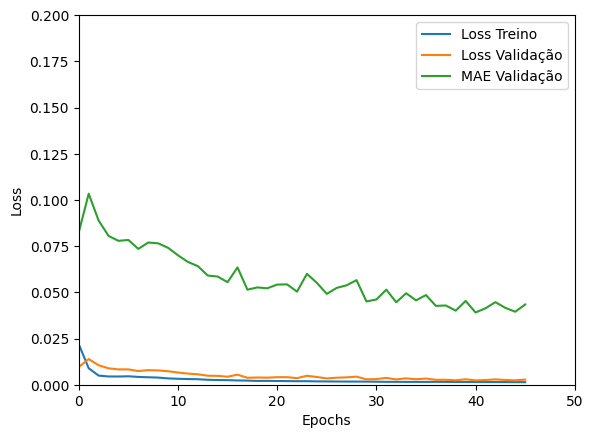

Tempo de treino: 0:03:26.196778
1/1 [==============================] - 0s 317ms/step
Treinando USDBRL=X com LSTM_v1, opt=sgd, units=32, batch=8, timesteps=20
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 32)                4352      
                                                                 
 dense_61 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.013738621026277542 , MAE = 0.10192644596099854'

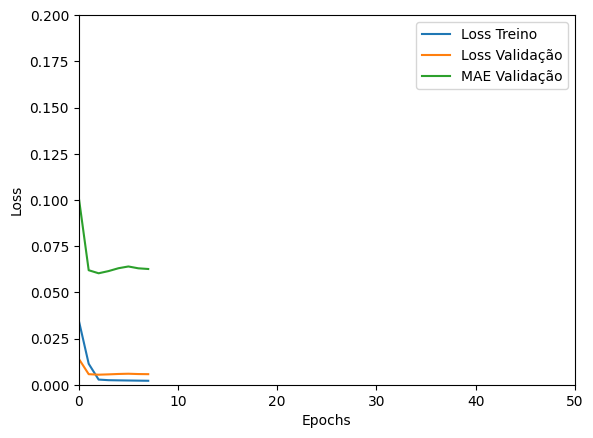

Tempo de treino: 0:00:47.333534
1/1 [==============================] - 0s 226ms/step
Treinando USDBRL=X com LSTM_v1, opt=sgd, units=32, batch=16, timesteps=20
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 32)                4352      
                                                                 
 dense_62 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.00494091771543026 , MAE = 0.0581943541765213'

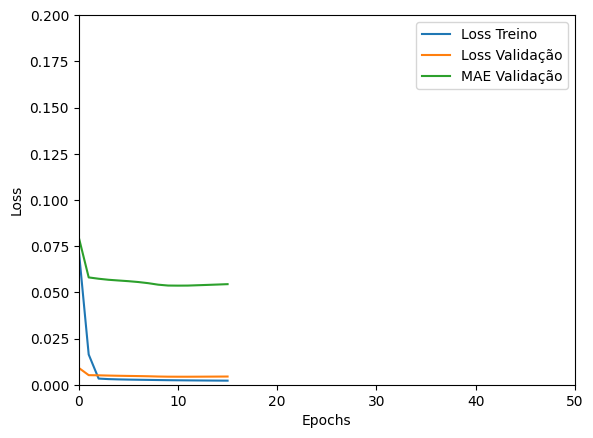

Tempo de treino: 0:01:24.834790
1/1 [==============================] - 0s 199ms/step
Treinando USDBRL=X com LSTM_v1, opt=sgd, units=64, batch=8, timesteps=20
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 64)                16896     
                                                                 
 dense_63 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.010536428540945053 , MAE = 0.08615177124738693'

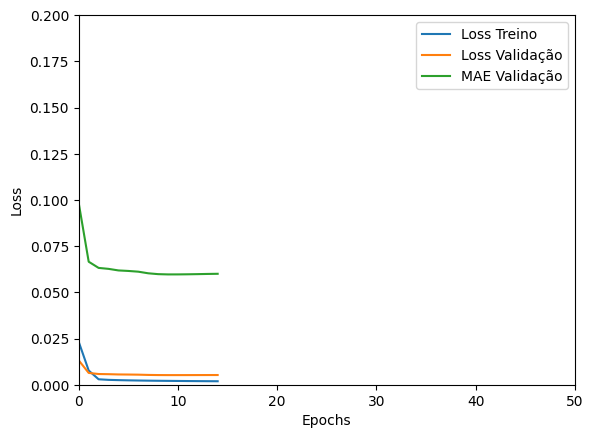

Tempo de treino: 0:01:28.254394
1/1 [==============================] - 0s 268ms/step
Treinando USDBRL=X com LSTM_v1, opt=sgd, units=64, batch=16, timesteps=20
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 64)                16896     
                                                                 
 dense_64 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.0029225172474980354 , MAE = 0.04258432239294052'

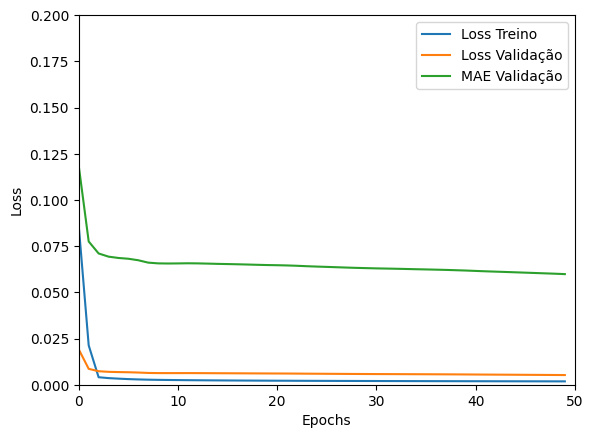

Tempo de treino: 0:03:26.041124
1/1 [==============================] - 1s 1s/step
Treinando USDBRL=X com LSTM_v2, opt=adam, units=32, batch=8, timesteps=20
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 32)                4352      
                                                                 
 dense_65 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.13586558401584625 , MAE = 0.32528987526893616'

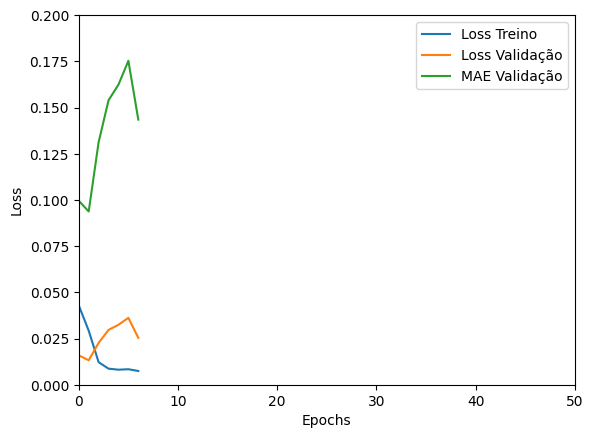

Tempo de treino: 0:00:45.946654
1/1 [==============================] - 0s 205ms/step
Treinando USDBRL=X com LSTM_v2, opt=adam, units=32, batch=16, timesteps=20
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 32)                4352      
                                                                 
 dense_66 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.036760177463293076 , MAE = 0.15372946858406067'

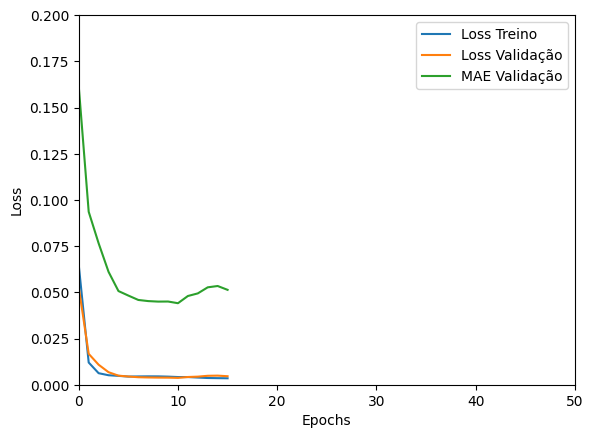

Tempo de treino: 0:00:47.918812
1/1 [==============================] - 0s 289ms/step
Treinando USDBRL=X com LSTM_v2, opt=adam, units=64, batch=8, timesteps=20
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 64)                16896     
                                                                 
 dense_67 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.5706439018249512 , MAE = 0.6175877451896667'

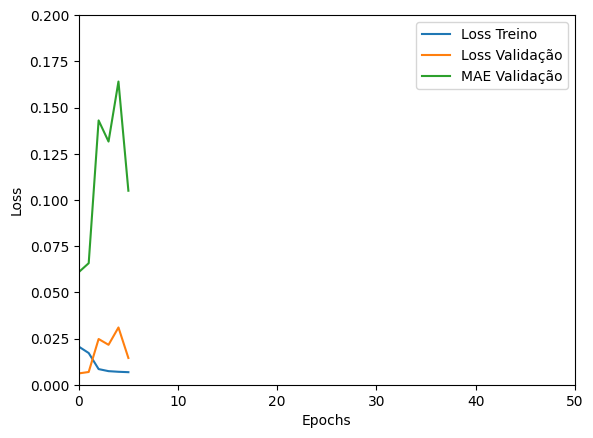

Tempo de treino: 0:00:45.586682
1/1 [==============================] - 0s 227ms/step
Treinando USDBRL=X com LSTM_v2, opt=adam, units=64, batch=16, timesteps=20
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 64)                16896     
                                                                 
 dense_68 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.04535027965903282 , MAE = 0.16849759221076965'

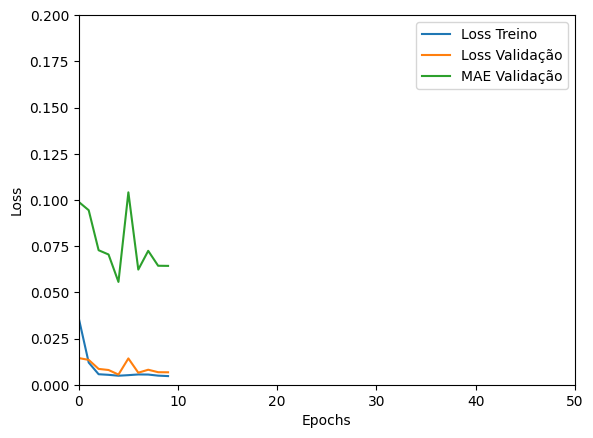

Tempo de treino: 0:00:44.572253
1/1 [==============================] - 0s 193ms/step
Treinando USDBRL=X com LSTM_v2, opt=sgd, units=32, batch=8, timesteps=20
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_79 (LSTM)              (None, 32)                4352      
                                                                 
 dense_69 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.008929772302508354 , MAE = 0.07625843584537506'

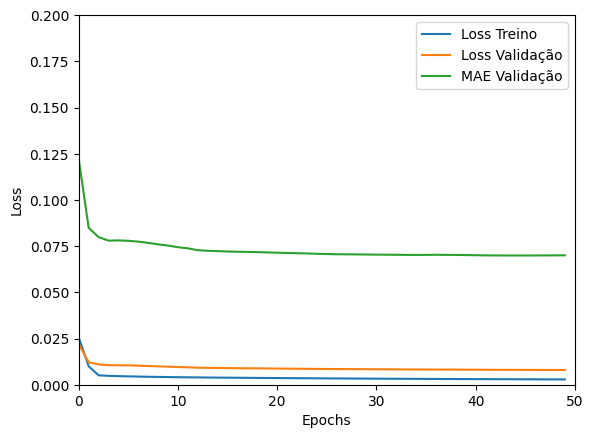

Tempo de treino: 0:04:22.109685
1/1 [==============================] - 0s 210ms/step
Treinando USDBRL=X com LSTM_v2, opt=sgd, units=32, batch=16, timesteps=20
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 32)                4352      
                                                                 
 dense_70 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.006711931433528662 , MAE = 0.057070061564445496'

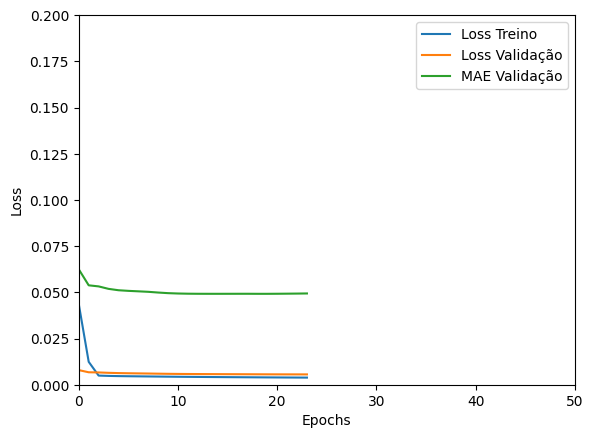

Tempo de treino: 0:01:24.792183
1/1 [==============================] - 0s 227ms/step
Treinando USDBRL=X com LSTM_v2, opt=sgd, units=64, batch=8, timesteps=20
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 64)                16896     
                                                                 
 dense_71 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.022385668009519577 , MAE = 0.11729415506124496'

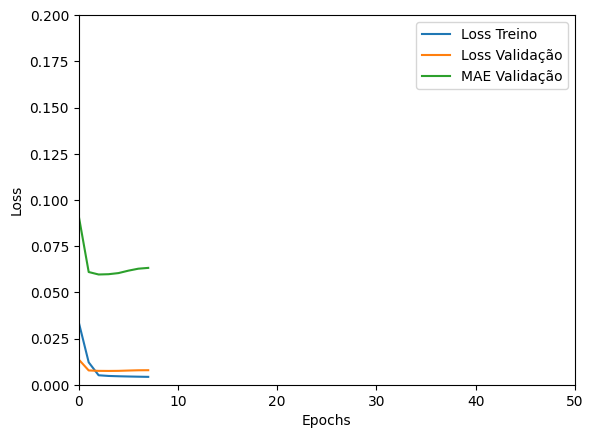

Tempo de treino: 0:01:28.061191
1/1 [==============================] - 0s 214ms/step
Treinando USDBRL=X com LSTM_v2, opt=sgd, units=64, batch=16, timesteps=20
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 64)                16896     
                                                                 
 dense_72 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

'TRAINING set. Loss = 0.009804845787584782 , MAE = 0.07105203717947006'

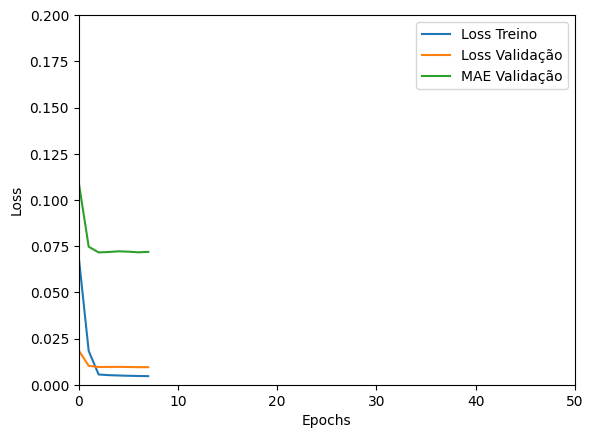

Tempo de treino: 0:00:28.585987
1/1 [==============================] - 0s 329ms/step

Tempo TOTAL de treino manual : 1:12:28.231234


In [16]:
inittime_manual = datetime.now()
for times in range(train_times):
  for stock in arr_acoes_hyperparams:
    for timesteps in timesteps_hyper:
      for model_type_str in model_hyperparams:
        if model_type_str == 'AUTO':
          continue
        elif model_type_str[:4] == 'LSTM':
          scaler, X_train, X_test, y_train, y_test = preprocess(df, stock, timesteps, len(data_teste))
        elif model_type_str[:3] == 'CNN':
          scaler, X_train, X_test, y_train, y_test = preprocess_CNN1D(df, stock, len(data_teste))
        for optimizer in optimizer_hyper:
          for unit in unit_hyper:
            for batch_size in batch_hyper:
              inittime = datetime.now()
              print(f"Treinando {stock} com {model_type_str}, opt={optimizer}, units={unit}, batch={batch_size}, timesteps={timesteps}")
              m, h = model_type(model_type_str, unit=unit, optimizer=optimizer, timesteps=timesteps, X=X_train, y=y_train, epochs=epochs, batch_size=batch_size)
              endtime = datetime.now()
              print(f'Tempo de treino: {endtime-inittime}' )
              y_pred = m.predict(X_test)
              score = m.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

              optimizer, num_layers, unit, activation, dropout_rate = get_model_info(m)
              mod_cfg_res = {'model_type': model_type_str, 'stock':stock, 'num_layers':num_layers ,'unit':unit,
                     'optimizer':optimizer, 'activation':activation,
                     'dropout_rate':dropout_rate, "mae":score[1], "mse":score[2],
                     "batch_size":batch_size, "timesteps":timesteps}


              all_results = all_results.append(mod_cfg_res, ignore_index=True)
              # save the model architecture to a JSON string
              fprefix = f"{stock}_{model_type_str}_{num_layers}_{unit}_{activation}_{optimizer}_{dropout_rate}_{batch_size}_{timesteps}"
              with open(f"{fprefix}.json", "w") as json_file:
                model_json = m.to_json()
                json_file.write(model_json)
                # serialize weights to HDF5
                m.save_weights(f"{fprefix}.h5")

              del m, h

endtime_manual = datetime.now()
print(f'\nTempo TOTAL de treino manual : {endtime_manual-inittime_manual}' )

## Avaliação na base de testes

### Funções de avaliação

In [17]:
def plot_bloxpot(aval):
  fig, ax = plt.subplots(figsize=(20, 7), nrows=1, ncols=2)
  sns.boxplot(data=aval.filter(regex=usdbrl), dodge=False, palette="Blues", ax=ax[0])
  sns.swarmplot(data=aval.filter(regex=usdbrl), color=".25", alpha=0.8, ax=ax[0])

  sns.boxplot(data=aval.filter(regex=eurobrl), dodge=False, palette="Blues", ax=ax[1])
  sns.swarmplot(data=aval.filter(regex=eurobrl), color=".25", alpha=0.8, ax=ax[1])

  ax[1].set_title("Performance Boxplot")

def plot_aval(aval):
  fig, ax = plt.subplots(figsize=(30, 12), nrows=1, ncols=2)

  sns.lineplot(data=aval.filter(regex=usdbrl), palette="inferno", ax=ax[0], hue_order=[f'{usdbrl}_Real' ,usdbrl])
  ax[0].set_xlabel('Dias')
  ax[0].set_title(usdbrl)

  sns.lineplot(data=aval.filter(regex=eurobrl), palette="inferno", ax=ax[1], hue_order=[f'{eurobrl}_Real', eurobrl])
  ax[1].set_xlabel('Dias')
  ax[1].set_title(eurobrl)

Desempenho ordenado por moeda e menor mse na base de testes

In [18]:
all_results.sort_values(by=['stock','mse'])

,model_type,stock,num_layers,unit,optimizer,activation,dropout_rate,mae,mse,batch_size,timesteps
0,AUTO,EURBRL=X,4,64,adam,tanh,0.2,0.023741,0.000989,8,10
2,AUTO,EURBRL=X,4,64,adam,tanh,0.2,0.025835,0.000989,8,20
3,AUTO,EURBRL=X,4,64,adam,tanh,0.2,0.025626,0.001033,16,20
8,LSTM_v1,EURBRL=X,2,32,adam,relu,0.0,0.031851,0.001410,8,10
29,LSTM_v1,EURBRL=X,2,32,sgd,relu,0.0,0.031350,0.001438,16,20
...,...,...,...,...,...,...,...,...,...,...,...
56,LSTM_v1,USDBRL=X,2,32,adam,relu,0.0,0.047221,0.003293,8,20
68,LSTM_v2,USDBRL=X,2,32,sgd,relu,0.0,0.047139,0.003440,8,20
57,LSTM_v1,USDBRL=X,2,32,adam,relu,0.0,0.052449,0.003533,16,20
66,LSTM_v2,USDBRL=X,2,64,adam,relu,0.0,0.050692,0.004716,8,20


É considerada a melhor média, em termos de MAE, das três execuções

In [19]:
# Melhor médias das execuções
print(f' Total results: {len(all_results)}')
mean_mse = all_results.groupby(['stock', 'model_type', 'num_layers', 'unit', 'activation', 'optimizer', 'dropout_rate', 'batch_size', 'timesteps'] )['mse'].mean()
mean_mse = mean_mse.reset_index()
display.display(mean_mse.sort_values(by=['stock','mse']))



 Total results: 72


,stock,model_type,num_layers,unit,activation,optimizer,dropout_rate,batch_size,timesteps,mse
0,EURBRL=X,AUTO,4,64,tanh,adam,0.2,8,10,0.000989
1,EURBRL=X,AUTO,4,64,tanh,adam,0.2,8,20,0.000989
3,EURBRL=X,AUTO,4,64,tanh,adam,0.2,16,20,0.001033
4,EURBRL=X,LSTM_v1,2,32,relu,adam,0.0,8,10,0.001410
11,EURBRL=X,LSTM_v1,2,32,relu,sgd,0.0,16,20,0.001438
...,...,...,...,...,...,...,...,...,...,...
41,USDBRL=X,LSTM_v1,2,32,relu,adam,0.0,8,20,0.003293
61,USDBRL=X,LSTM_v2,2,32,relu,sgd,0.0,8,20,0.003440
43,USDBRL=X,LSTM_v1,2,32,relu,adam,0.0,16,20,0.003533
65,USDBRL=X,LSTM_v2,2,64,relu,adam,0.0,8,20,0.004716


Seleção dos melhores modelos de cada arquitetura


In [20]:
best_models_arr = []

# Maybe you want to check best models by type of model
# for model_str in model_hyperparams:

for stock in arr_acoes:
  best_model = mean_mse[mean_mse['stock'] == stock].sort_values('mse', ascending=True).head(1)
  bm = best_model.iloc[0]
  fprefix = f"{stock}_{bm['model_type']}_{bm['num_layers']}_{bm['unit']}_{bm['activation']}_{bm['optimizer']}_{bm['dropout_rate']}_{bm['batch_size']}_{bm['timesteps']}"
  # load json and create model
  json_file = open(f'{fprefix}.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(f"{fprefix}.h5")
  best_model['model'] = loaded_model

  best_models_arr.append(pd.DataFrame(best_model))

best_models_df = pd.concat(best_models_arr)
del best_models_arr
print("Melhores modelos")
display.display(best_models_df.sort_values('mse', ascending=True))
# display.display(best_models_df)

Melhores modelos


,stock,model_type,num_layers,unit,activation,optimizer,dropout_rate,batch_size,timesteps,mse,model
0,EURBRL=X,AUTO,4,64,tanh,adam,0.2,8,10,0.000989,<keras.src.engine.sequential.Sequential object...
39,USDBRL=X,AUTO,4,64,tanh,adam,0.2,16,20,0.001121,<keras.src.engine.sequential.Sequential object...


### Boxplot

Construção dos dados de predição, também usados no Boxplot e Swarmplot

---

In [21]:
aval = pd.DataFrame()

for index, setup in best_models_df.iterrows():

  scaler, X_train, X_test, y_train, y_test = preprocess(df, setup["stock"], setup["timesteps"] , len(data_teste))

  mod = setup['model']

  y_pred = mod.predict(X_test)
  y_pred = scaler.inverse_transform(y_pred)
  y_real = scaler.inverse_transform(y_test)

  aval[f'{setup["stock"]}'] = y_pred[:,0]
  aval[f'{setup["stock"]}_Real'] = y_real[:,0]



1/1 [==============================] - 1s 876ms/step


Figura com boxplot e swarmplot para os melhores modelos

---

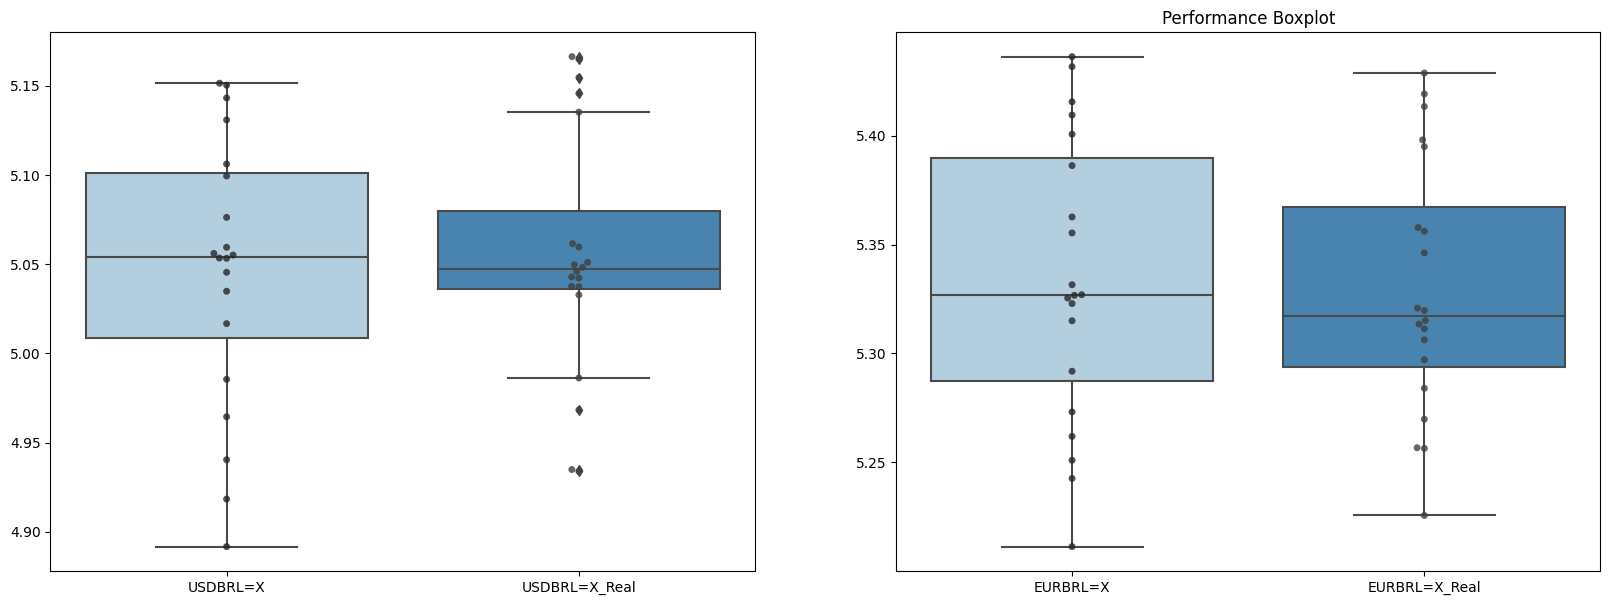

In [22]:
plot_bloxpot(aval)

### Performance

Figura predição por moeda

    EURBRL=X  EURBRL=X_Real  USDBRL=X  USDBRL=X_Real
0   5.211272         5.2564  4.891675         4.9349
1   5.242607         5.2256  4.918346         4.9339
2   5.250951         5.2567  4.940380         4.9683
3   5.261896         5.2698  4.964467         4.9862
4   5.273151         5.2971  4.985461         5.0422
5   5.291841         5.3197  5.016658         5.0328
6   5.315004         5.3151  5.034815         5.0428
7   5.326992         5.3063  5.045443         5.0615
8   5.326698         5.3950  5.056018         5.1663
9   5.362695         5.4134  5.099401         5.1546
10  5.400712         5.3981  5.130833         5.1650
11  5.415581         5.4288  5.150310         5.1457
12  5.431739         5.4192  5.151406         5.1352
13  5.436323         5.3578  5.143135         5.0510
14  5.409488         5.3561  5.106139         5.0496
15  5.386299         5.3113  5.076202         5.0459
16  5.355354         5.2840  5.059453         5.0482
17  5.325451         5.3135  5.055066         

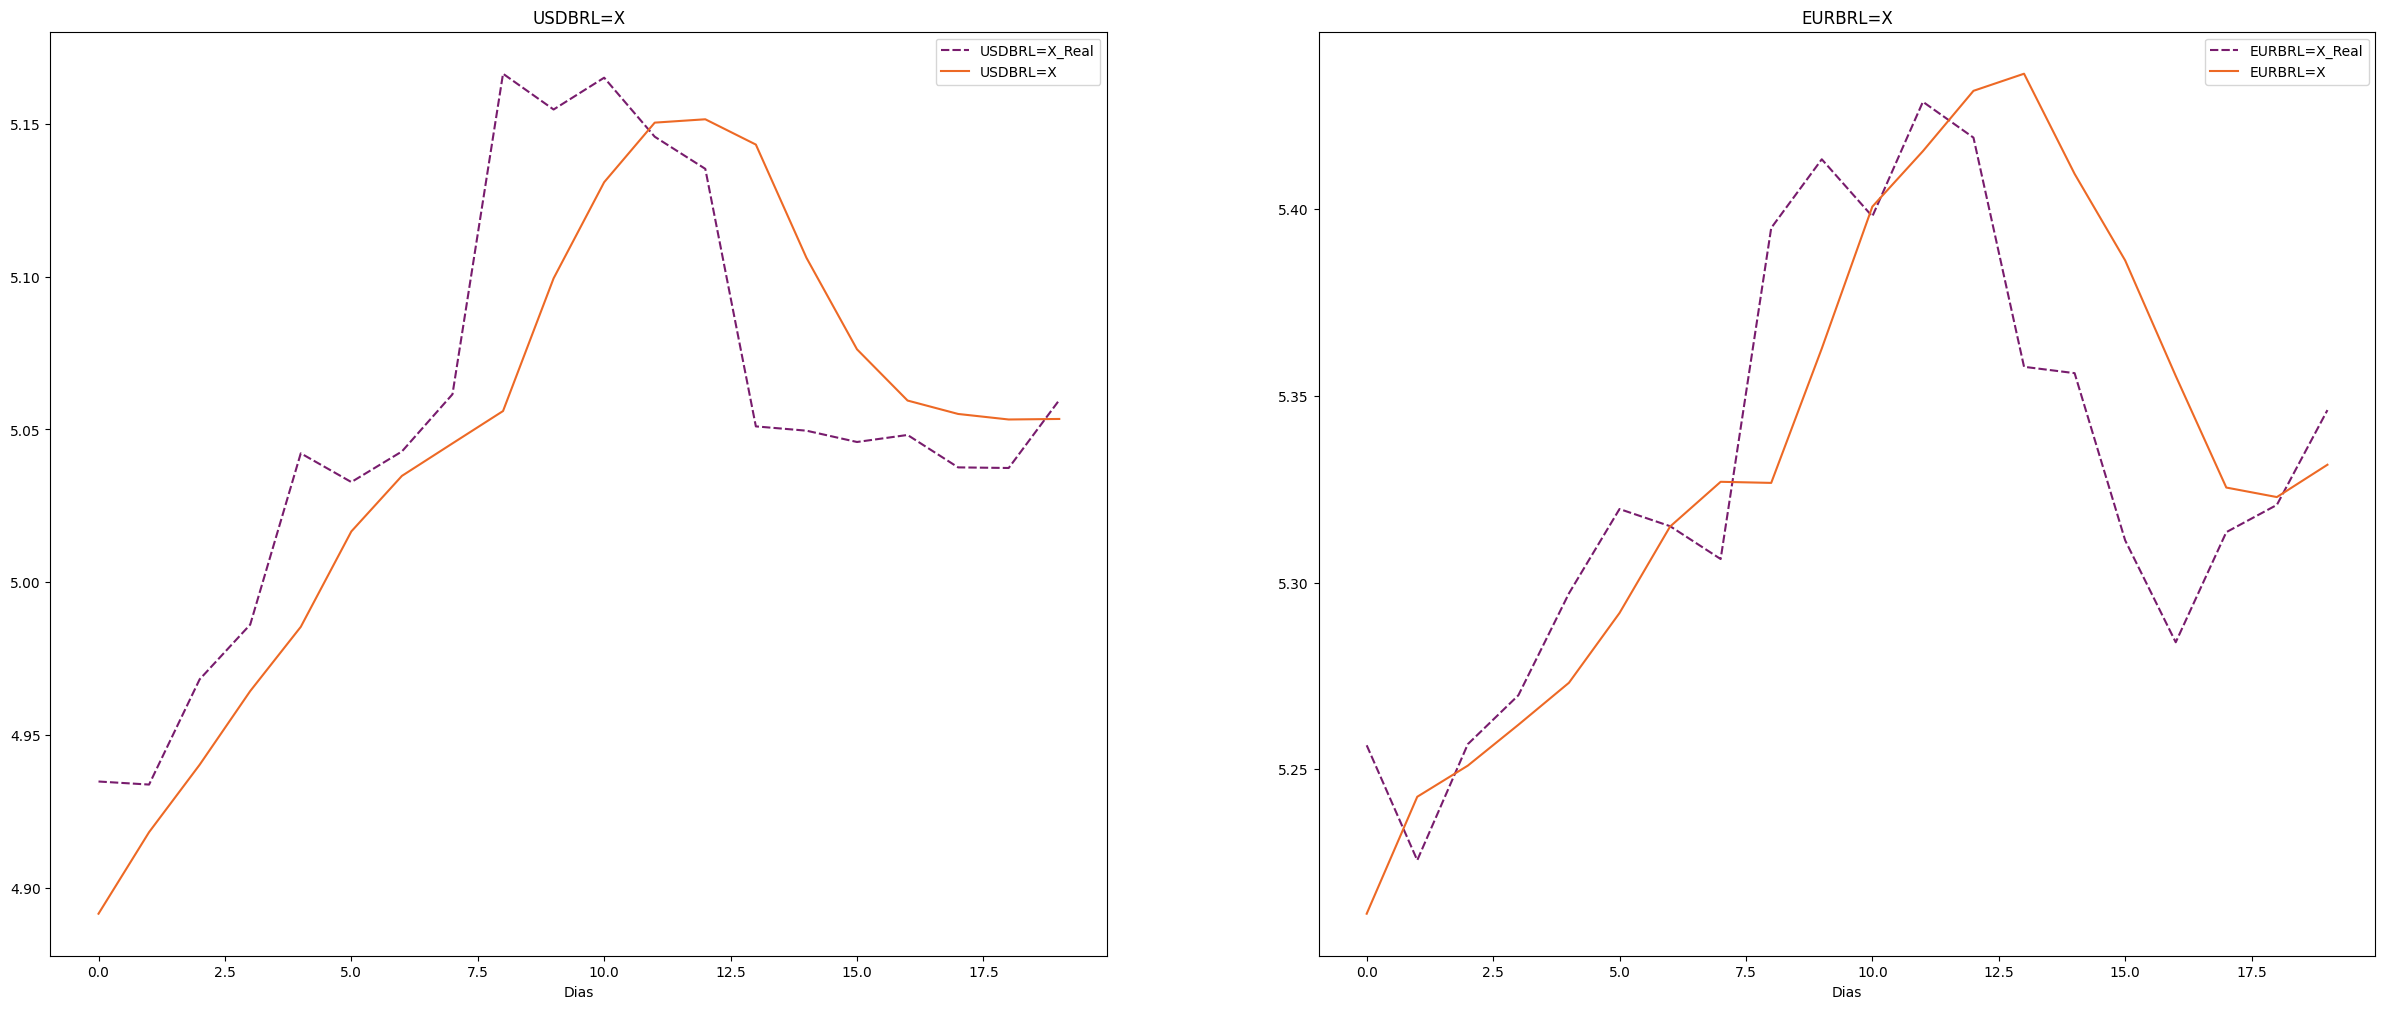

In [23]:
plot_aval(aval)
print(aval)

## Avaliação usando técnica para futuro - últimos dias da série


Avaliação usando técnica de predição no futuro, nos últimos test_fut_days de observação reais

In [24]:
aval_fut = pd.DataFrame()

sharpness = None
test_fut_days = 20
for index, setup in best_models_df.iterrows():

  scaler, X_train, X_test, y_train, y_test = preprocess(df, setup['stock'], setup["timesteps"], test_fut_days)
  # inittime = datetime.now()
  # print(f"Usando {setup['stock']} com {setup['model_type']} , units={setup['unit']}, batch={setup['batch_size']}, \
  #   timesteps={setup['timesteps']}")
  print(f"Usando {setup}")

  m = setup['model']

  # Initial sequence for prediction
  initial_sequence = X_test[0]
  # Predict future values iteratively
  predicted_values = []

  for _ in range(test_fut_days):
    # Predict the next step
    next_step = m.predict(np.array([initial_sequence]))
    if sharpness is not None:
      next_step[0, 0] = next_step[0, 0] + next_step[0, 0]*uniform(-sharpness, sharpness)
    # Append the predicted value
    predicted_values.append(next_step[0, 0])
    # Update the initial sequence by removing the oldest value and appending the predicted value
    initial_sequence = np.roll(initial_sequence, shift=-1, axis=0)
    initial_sequence[-1] = next_step[0, 0]

  y_pred = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
  y_real = scaler.inverse_transform(y_test)
  aval_fut[f'{setup["stock"]}'] = y_pred[:,0]
  aval_fut[f'{setup["stock"]}_Real'] = y_real[:,0]



Usando stock                                                    EURBRL=X
model_type                                                   AUTO
num_layers                                                      4
unit                                                           64
activation                                                   tanh
optimizer                                                    adam
dropout_rate                                                  0.2
batch_size                                                      8
timesteps                                                      10
mse                                                      0.000989
model           <keras.src.engine.sequential.Sequential object...
Name: 0, dtype: object
1/1 [==============================] - 0s 26ms/step
Usando stock                                                    USDBRL=X
model_type                                                   AUTO
num_layers                                           

### Boxplot

Figura com boxplot e swarmplot para os melhores modelos

---

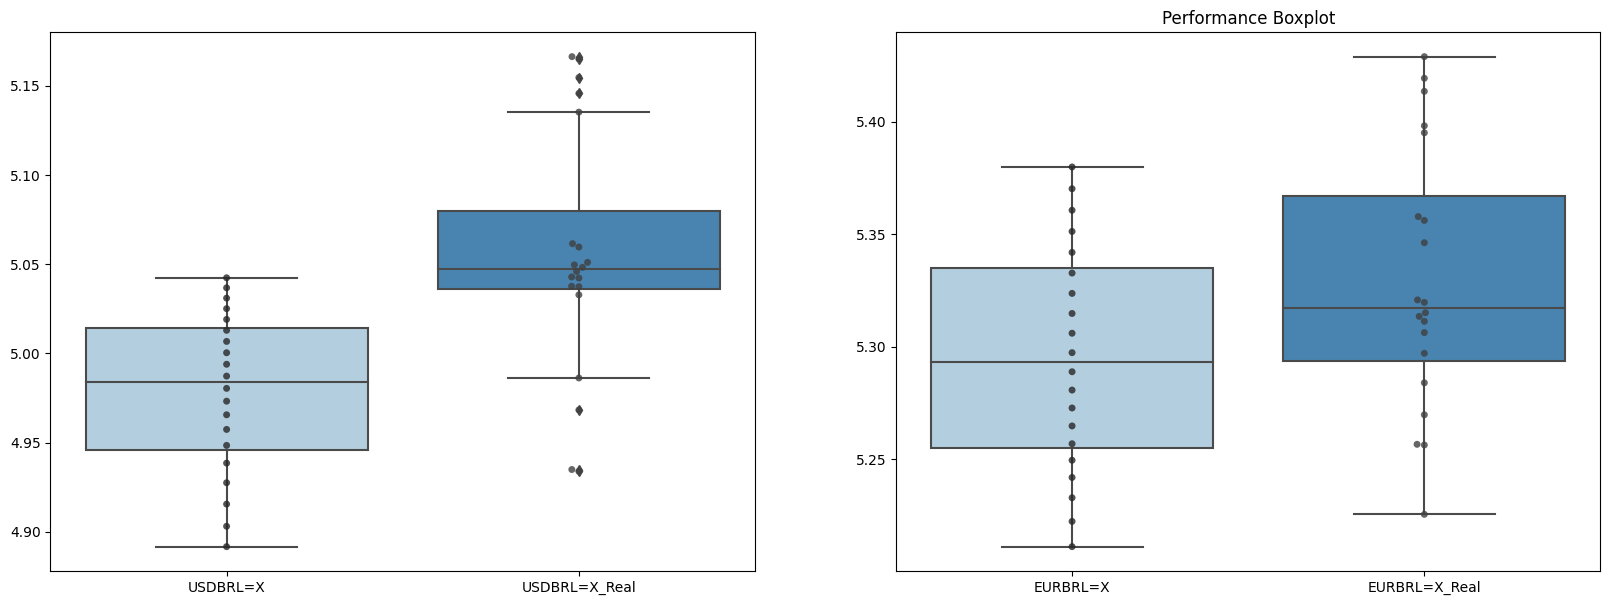

In [25]:
plot_bloxpot(aval_fut)

### Performance

Figura predição por moeda

    EURBRL=X  EURBRL=X_Real  USDBRL=X  USDBRL=X_Real
0   5.211272         5.2564  4.891675         4.9349
1   5.222483         5.2256  4.903083         4.9339
2   5.232980         5.2567  4.915507         4.9683
3   5.241987         5.2698  4.927481         4.9862
4   5.249626         5.2971  4.938486         5.0422
5   5.256953         5.3197  4.948411         5.0328
6   5.264851         5.3151  4.957370         5.0428
7   5.272825         5.3063  4.965569         5.0615
8   5.280781         5.3950  4.973197         5.1663
9   5.288907         5.4134  4.980380         5.1546
10  5.297385         5.3981  4.987247         5.1650
11  5.306009         5.4288  4.993886         5.1457
12  5.314785         5.4192  5.000353         5.1352
13  5.323694         5.3578  5.006695         5.0510
14  5.332730         5.3561  5.012911         5.0496
15  5.341897         5.3113  5.019032         5.0459
16  5.351192         5.2840  5.025055         5.0482
17  5.360610         5.3135  5.030957         

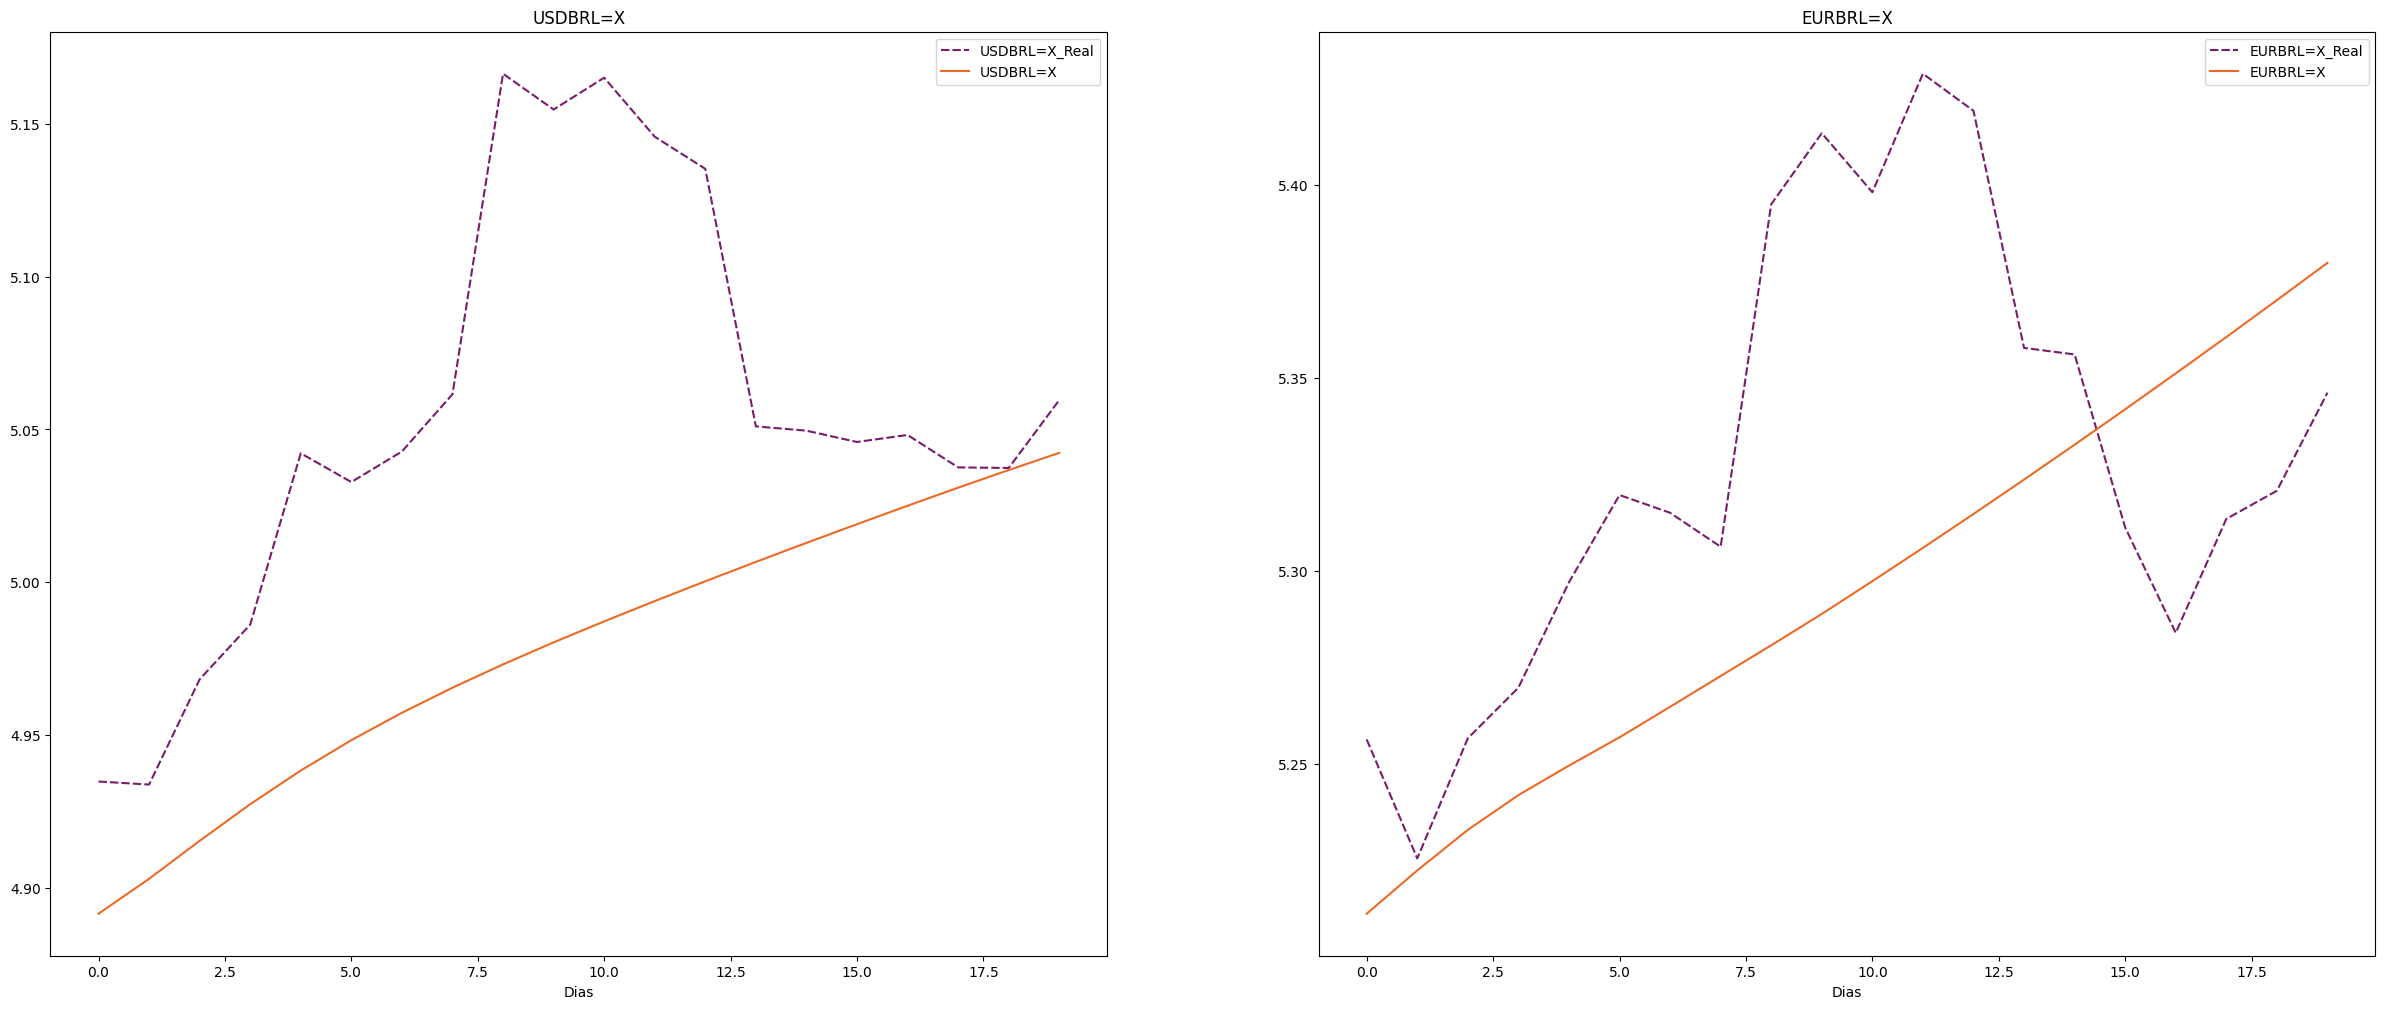

In [26]:
plot_aval(aval_fut)
print(aval_fut)

Erro

In [27]:
aval_err = pd.DataFrame(columns=['EURBRL_bias', 'USDBRL_bias'])
aval_err['EURBRL_bias'] = 100*abs(aval_fut['EURBRL=X']-aval_fut['EURBRL=X_Real'])/aval_fut['EURBRL=X_Real']
aval_err['USDBRL_bias'] = 100*abs(aval_fut['USDBRL=X']-aval_fut['USDBRL=X_Real'])/aval_fut['USDBRL=X_Real']
print(aval_err)

    EURBRL_bias  USDBRL_bias
0      0.858532     0.875891
1      0.059650     0.624588
2      0.451230     1.062597
3      0.527789     1.177633
4      0.896233     2.056929
5      1.179513     1.676775
6      0.945412     1.694092
7      0.630861     1.895318
8      2.117122     3.737749
9      2.299730     3.379904
10     1.865743     3.441500
11     2.261850     2.950317
12     1.926751     2.625929
13     0.636563     0.877159
14     0.436321     0.726569
15     0.576087     0.532460
16     1.271614     0.458484
17     0.886620     0.131874
18     0.927551     0.013319
19     0.628909     0.340918


## Avaliação usando técnica para futuro - dias futuros

Avaliação usando técnica de predição no futuro, para os próximos fut_days dias futuros

In [28]:
aval_fut = pd.DataFrame()

sharpness = None
test_fut_days = 20
for index, setup in best_models_df.iterrows():

  scaler, X_train, X_test, y_train, y_test = preprocess(df, setup['stock'], setup["timesteps"], 0)

  m = setup['model']

  # Initial sequence for prediction
  initial_sequence = X_train[-1]
  # Predict future values iteratively
  predicted_values = []

  for _ in range(test_fut_days):
    # Predict the next step
    next_step = m.predict(np.array([initial_sequence]), verbose=False)
    if sharpness is not None:
      next_step[0, 0] = next_step[0, 0] + next_step[0, 0]*uniform(-sharpness, sharpness)
    predicted_values.append(next_step[0, 0])
    # Update the initial sequence by removing the oldest value and appending the predicted value
    initial_sequence = np.roll(initial_sequence, shift=-1, axis=0)
    initial_sequence[-1] = next_step[0, 0]

  y_pred = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
  aval_fut[f'{setup["stock"]}'] = y_pred[:,0]


### Boxplot

Figura com boxplot e swarmplot para os melhores modelos

---

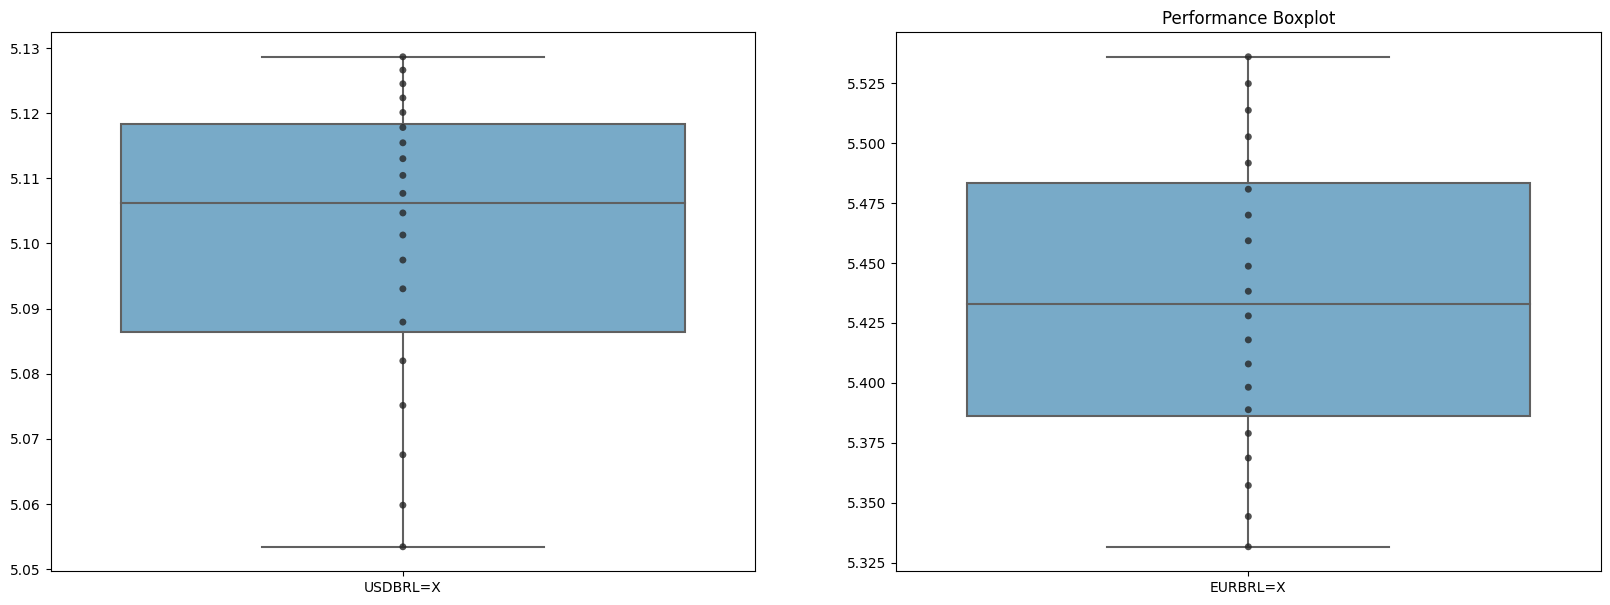

In [29]:
plot_bloxpot(aval_fut)

### Performance

### Figuras predição por moeda
Fazer cópias da imagem da previsão e salvar

Predicting from 2023-10-19 00:00:00 to 2023-11-08 00:00:00
    EURBRL=X  USDBRL=X
0   5.331562  5.053429
1   5.344217  5.059816
2   5.357148  5.067550
3   5.368604  5.075133
4   5.378878  5.081972
5   5.388761  5.087923
6   5.398146  5.093028
7   5.407856  5.097443
8   5.417908  5.101287
9   5.427923  5.104676
10  5.438193  5.107681
11  5.448658  5.110440
12  5.459266  5.113005
13  5.469981  5.115443
14  5.480791  5.117793
15  5.491688  5.120099
16  5.502666  5.122334
17  5.513724  5.124504
18  5.524855  5.126609
19  5.536054  5.128648


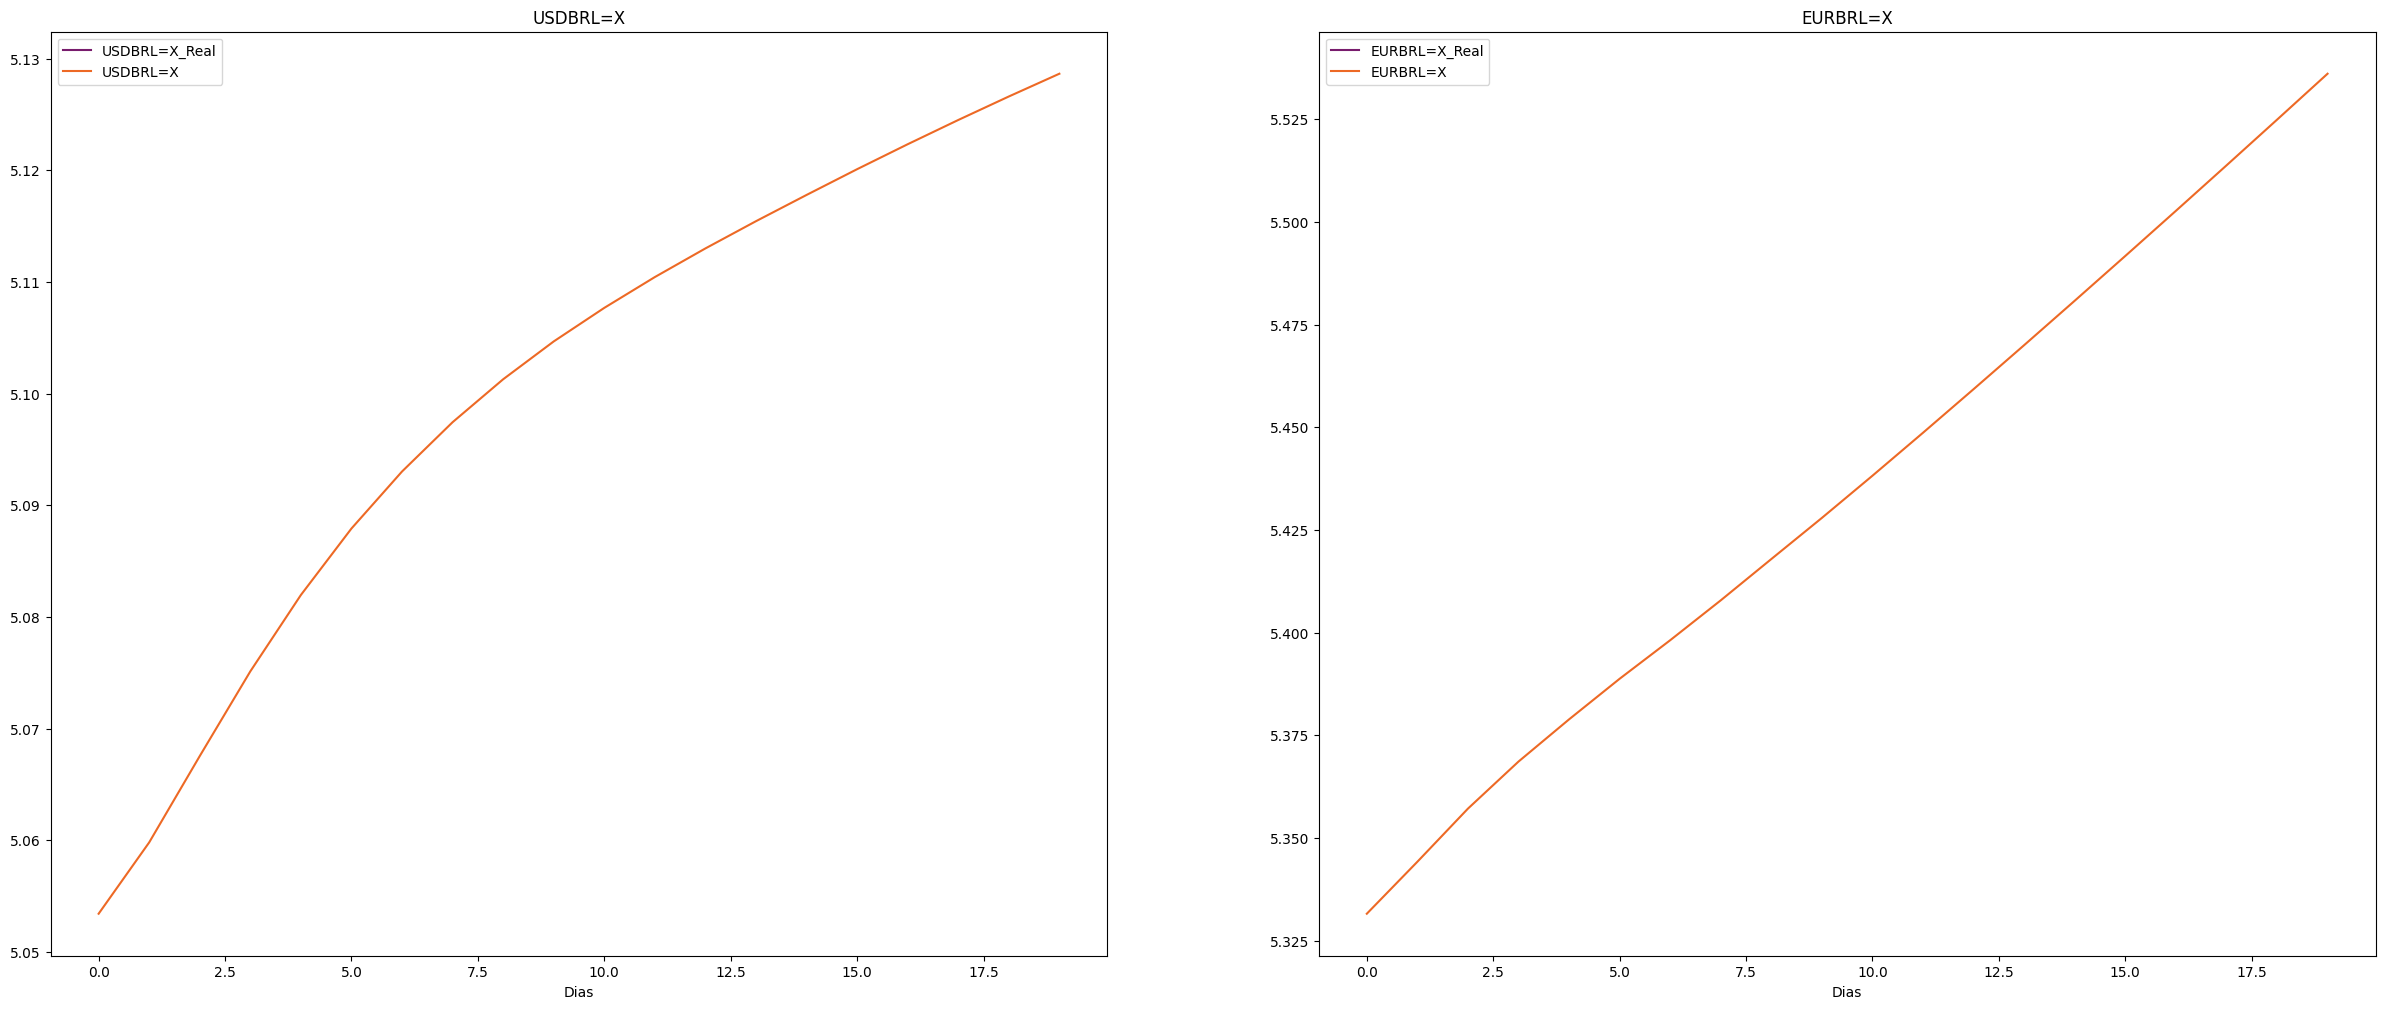

In [34]:
today = df.index.max()
last_pred_day = today + timedelta(days=test_fut_days)
print(f'Predicting from {today} to {last_pred_day}')
plot_aval(aval_fut)
# print(aval_fut)

Previsão dia 19/10 a 08/11
Usando melhor modelo encontrado

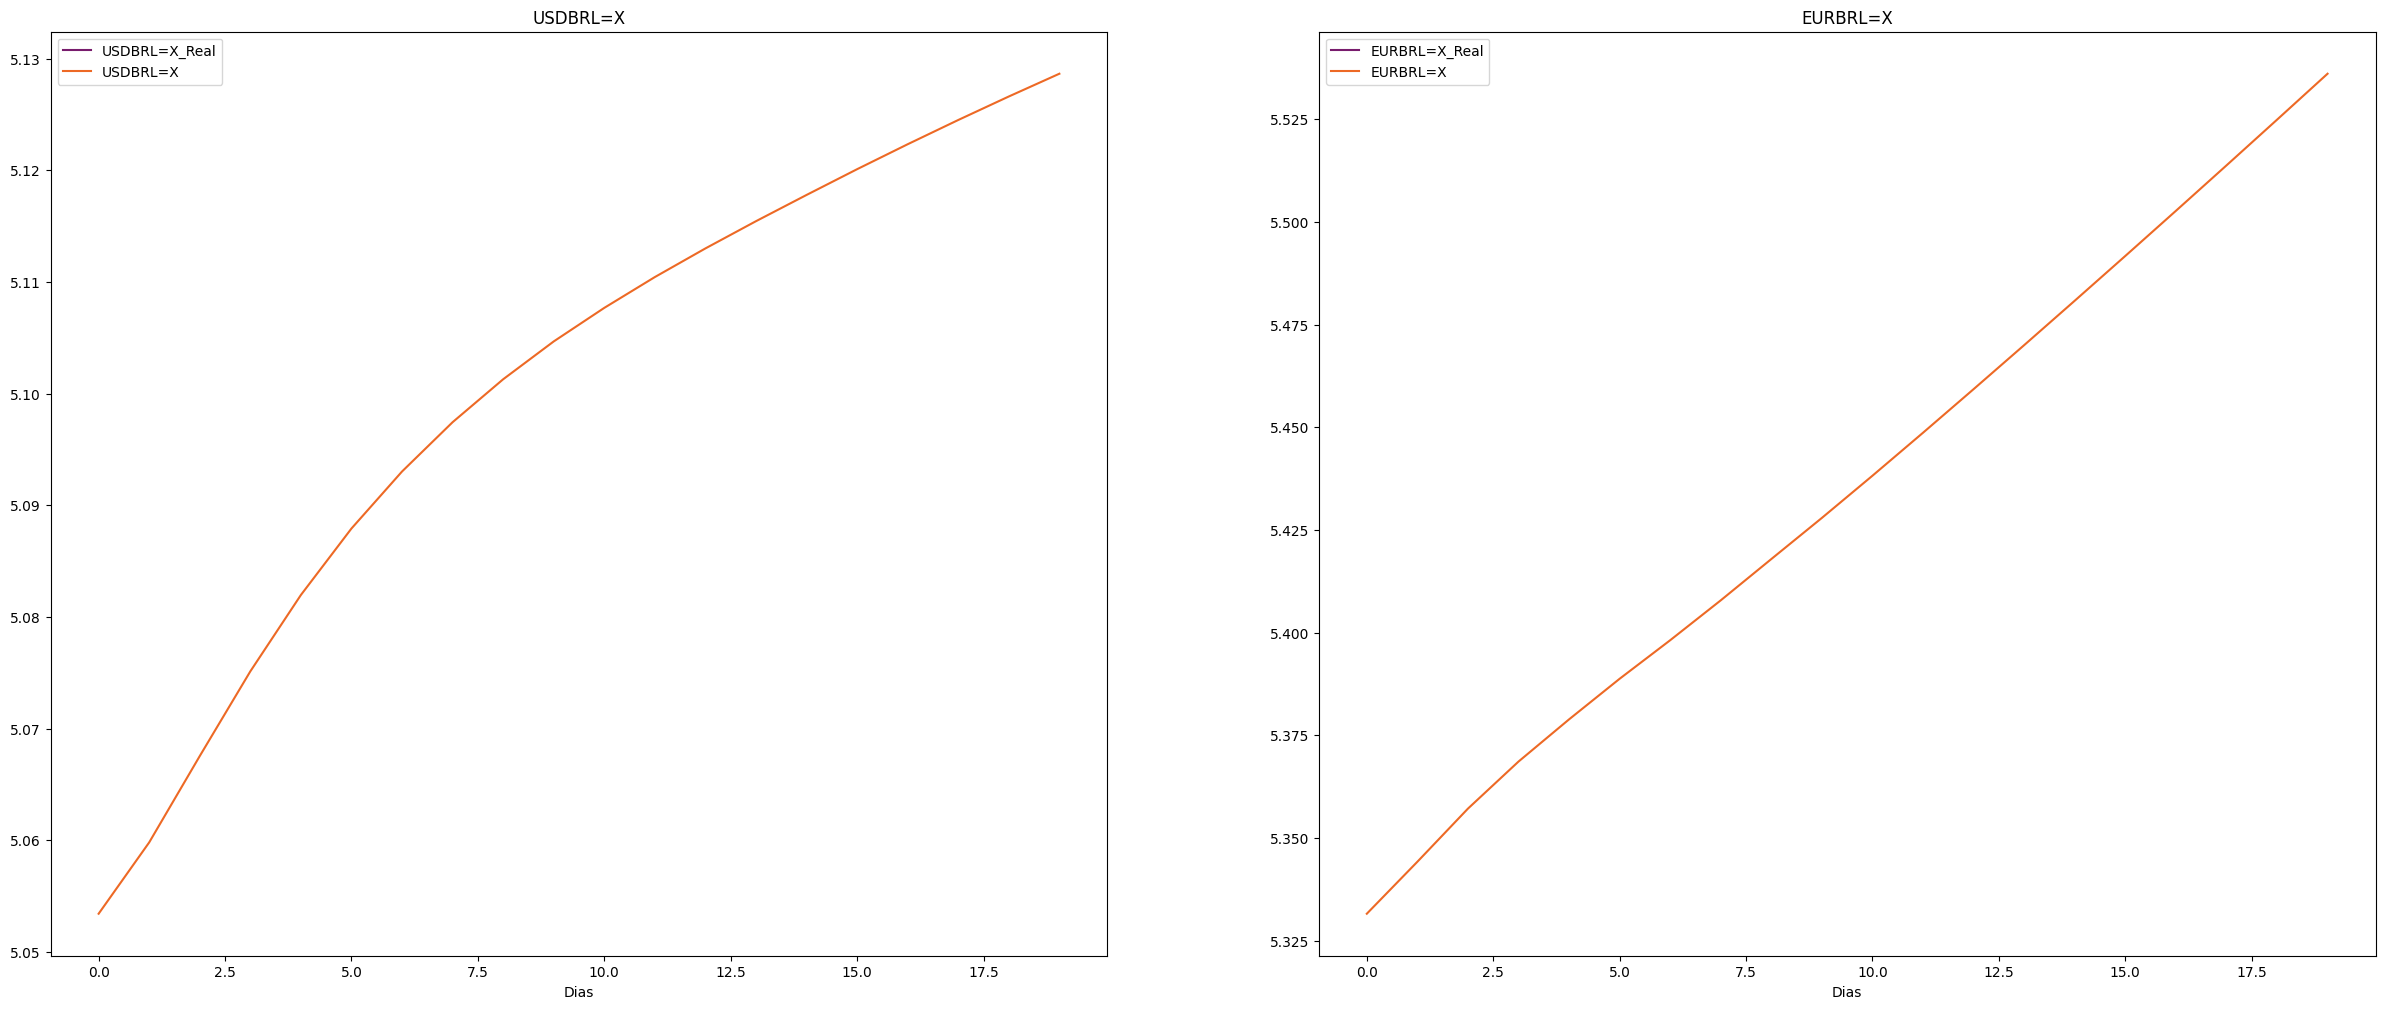

## Conclusão

In [32]:
ends_at = datetime.now()

for model_str in model_hyperparams:
  for stock in arr_acoes:
    best_model = mean_mse[mean_mse['stock'] == stock].sort_values('mse', ascending=True).head(1)
    bm = best_model.iloc[0]


print(f'Tempo TOTAL do treino AUTO   : {endtime_auto-inittime_auto}')
print(f'Tempo TOTAL de treino MANUAL : {endtime_manual-inittime_manual}')
print(f'Fim da execução do notebook  : {ends_at}')

print(f'\nTEMPO TOTAL DE EXECUÇÃO      : {ends_at-starts_at}')



Tempo TOTAL do treino AUTO   : 0:55:24.280235
Tempo TOTAL de treino MANUAL : 1:12:28.231234
Fim da execução do notebook  : 2023-10-19 16:59:52.054352

TEMPO TOTAL DE EXECUÇÃO      : 2:08:15.784922
